In [1]:
import warnings
import quantecon as qe
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import numpy as np
import scipy
%matplotlib inline


warnings.filterwarnings("ignore", category=RuntimeWarning)

plt.style.use('seaborn-notebook')


## Homework 2

### Hasan Cetin

---

# Question 1: Stochastic Growth Model with Leisure


$$\max_{c_t, k_{t+1}, h_t, x_t}\mathbb{E}\sum_{t=0}^{\infty} \beta^t \; [log(c_t) + \psi log(1 - h_t)]N_t$$

$$s.t. \; 0 = k_t^\alpha[(1+\gamma_z)^tz_t h_t]^{1-\alpha} - c_t - x_t  \text{(Feasibility Condition)}$$
$$ 0 = [(1-\delta)k_t + x_t]N_t - N_{t+1}k_{t+1} \;\;(Aggregate \; Law \; of \; Motion)$$
$$log(z_t) = \rho log(z_{t-1}) + \epsilon_t \;\; (Shocks)$$
$$N_t = (1+\gamma_n)^t \;\; (Population \; Growth)$$

The trick to get rid of $\gamma_z$: $log(c_t) = log(\frac{c_t (1+\gamma_z)^t}{(1+\gamma_z)^t}) = log(\hat{c_t}) + t log(1+\gamma_z)$ Do this trick for all the variables, then put resource and law of motion constraints into the objective function and you get:

**(Note: One beauty of this trick is that since $tlog(1+\gamma_z)$) part does not change policy function, we can get rid of it in the objective function, which we will do in VFI)**

$$\max_{\hat{k_{t+1}}, h_t}\mathbb{E}\sum_{t=0}^{\infty} \hat{\beta}^t[log(\hat{k_t}^\alpha (z_th_t)^{1-\alpha} + (1-\delta)\hat{k_t} - \hat{\gamma}\hat{k_{t+1}}) + \psi log(1 - h_t) + tlog(1+\gamma_z)]$$

$$s.t. \hat{\beta} = \beta (1+\gamma_n),\;\; \hat{\gamma} = (1+\gamma_n)(1+\gamma_z)$$

FOC:

$$ (h_t): \;\;\; \dfrac{(1-\alpha)\hat k_t^\alpha (z_t)^{1-\alpha} h_t^{-\alpha}}{\hat k_t ^\alpha (z_t h_t)^{1-\alpha} + (1-\delta )\hat k_t- \hat{\gamma}\hat k_{t+1}} = \dfrac{\psi}{1-h_t}$$

$$(\hat k_{t+1}): \;\;\; \dfrac{\hat{\gamma}}{\hat k_t ^\alpha (z_t h_t)^{1-\alpha} + (1-\delta )\hat k_t- \hat{\gamma}\hat k_{t+1}} = \hat{\beta} \mathbb{E}[\dfrac{\alpha \hat{k_{t+1}}^{\alpha-1}(z_{t+1}h_{t+1})^{1-\alpha} + (1-\delta)}{\hat k_{t+1} ^\alpha (z_{t+1} h_{t+1})^{1-\alpha} + (1-\delta )\hat k_{t+1}- \hat{\gamma}\hat k_{t+2}}]$$

Let's find the steady state (it will be useful for LQ model). 

Now, first of all, let's find z: $log(z_t) = \rho log(z_{t-1}) + \epsilon_t$ and when we are computing for steady state, we put means of the random variables. Let's assume $\epsilon \sim N(0, \sigma)$, then $log(z) = \rho log(z)$. Assuming $\rho < 1$, then z needs to be 1. 

$$z_{ss} = 1$$

$$log(z_{ss}) = 0$$

Now, let's find steady state for k and h: To do this use FOC equations and get rid of subscript t:

$$ (h): \;\;\; \dfrac{(1-\alpha)\hat{k}^\alpha (z)^{1-\alpha} h^{-\alpha}}{\hat{k}^\alpha (zh)^{1-\alpha} + (1-\delta - \hat{\gamma})\hat{k}} = \dfrac{\psi}{1-h}$$

$$(\hat k): \;\;\; \hat{\gamma} = \hat{\beta} [\alpha \hat{k}^{\alpha-1}h^{1-\alpha} + (1-\delta)]$$

Plug z = 1 and it is two unknown two equation problem. After some calculations we have:


$$ \Lambda = (\dfrac{\frac{\hat{\gamma}}{\hat{\beta}} - (1-\delta)}{\alpha})^{\frac{1}{1-\alpha}}$$

$$\Theta = \dfrac{(1-\alpha)\Lambda^{-1}}{\Lambda^{1-\alpha}+(1-\delta - \hat{\gamma})}$$

$$h_{ss} = [1 + \dfrac{\psi}{\Lambda \Theta}]^{-1}$$

$$k_{ss} = \dfrac{1 - h_{ss}}{\psi} \Theta$$




So, our steady state is:


$$(z_{ss}, h_{ss}, k_{ss}) = (1, [1 + \dfrac{\psi}{\Lambda \Theta}]^{-1}, \dfrac{1 - h_{ss}}{\psi} \Theta)$$

## Method 1: Value Function Iteration

$$V(z_t, \hat k_t) = max_{\{\hat k_{t+1}, h_t\}} \{ [log(\hat k_t ^\alpha (z_th_t)^{1-\alpha} + (1-\delta)\hat k_t - \hat{\gamma}\hat k_{t+1}) + \psi log(1 - h_t)] + \hat \beta \mathbb{E}[V(z_{t+1}, \hat k_{t+1})]\}$$

Now, how to solve maximization problem with two variables? We can write $h_t$ as a function of $z_t, \hat k_t, \hat k_{t+1}$, i.e. solve $h_t$ first. Then the rest is the same as what we did in HW 1, just plug in $h_t$ for each $k_{t+1}$ on K-grid and calculate the maximum.

But solving $h_t$ for each possible $z_t, \hat k_t, \hat k_{t+1}$ took forever. Instead of 'solving' the h, we create a grid for h values and for each possible $\hat k, \hat k', z$ it will take the maximum from that grid.

We also know that since h is labor, it should be bounded between 0 and 1. Therefore, we will create 100x1 grid between 0 and 1 for h.

After solving for h, then all the rest will be the same with what we did in HW1.

In [101]:
# @title Default title text
class VFI:
    def __init__(self, p=0.9, capital_size=150, shock_size=50, h_grid_size=100, z_bar=0, var=0.01,
                 δ=0.9, θ=0.7, β=0.95, γ_z=0.01, γ_n=0.01, ψ=0.5, ϵ=10e-5, max_iter=10000):
        self.p = p                       # \rho in AR(1) process in technology
        self.β = β                       # discount factor
        self.θ = θ                       # capital share
        self.δ = δ                       # depreciation rate of capital
        self.ψ = ψ                       # parameter for valuing leisure
        self.shock_size = shock_size     # Grid size for shocks
        self.capital_size = capital_size  # Capital stock grid size
        self.h_grid_size = h_grid_size   # h grid size
        self.z_bar = z_bar                   # Initial technology parameter
        self.ϵ = ϵ                       # Tolerance of convergence
        self.γ_z = γ_z                   # growth rate of capital
        self.γ_n = γ_n                   # growth rate of population
        # it turns to 1 if our model converges, useful for shortcut
        self.converge = 0

        self.β_hat = β * (1 + γ_n)       # Normalized beta
        self.γ_hat = (1 + γ_n) * (1 + γ_z)  # Normalized gamma

        self.max_iter = max_iter         # Maximum iteration
        self.iterations = 0              # Iteration number of the VFI process

        self.V = np.zeros((shock_size, capital_size))  # Initial V(Z,K)
        self.TV = np.ones((shock_size, capital_size))  # Initial TV(Z,K)

        # Initial policy function for k
        self.k_policy = np.zeros((shock_size, capital_size))
        # Initial policy function for h
        self.h_policy = np.ones((shock_size, capital_size))

        self.Markov = qe.markov.approximation.rouwenhorst(
            shock_size, z_bar, var, p)    # Discretized Gaus linear AR(1)
        self.Π = self.Markov.P          # Transition Matrix of the process

        # Transform \hat{z} = log(z) to real z
        self.Z = np.exp(self.Markov.state_values)
        #self.K_max = self.Z[-1]/((self.γ_hat- (1-δ))**(1/(1-θ)))  # Max capital stock with best shock full labor, 0 consumption
        self.K_max = 2.5
        # Capital stock grid
        self.K = np.linspace(0.1, self.K_max, capital_size)
        self.h_grid = np.linspace(0.01, 0.99, h_grid_size).reshape(
            (h_grid_size, 1))  # Our h grid

    def Utility(self, x, h):
        """Agent's utility function"""
        return np.log(x) + self.ψ * np.log(1-h)

    def update(self):
        """This function iterates once, i.e. finds TV, given V"""
        δ, γ_hat, ψ, shock_size, capital_size, K, Π, θ, β_hat, Z = self.δ, self.γ_hat, self.ψ, self.shock_size, self.capital_size, self.K, self.Π, self.θ, self.β_hat, self.Z
        H = self.h_grid.reshape((self.h_grid_size, 1))
        self.V = np.copy(self.TV)
        for s in range(shock_size):
            for k in range(capital_size):
                self.TV[s, k] = np.nanmax(self.Utility((Z[s] * H)**(1-θ) * K[k]**θ + (
                    1-δ) * K[k] - γ_hat * K, H) + β_hat * np.matmul(Π[s, :], self.V))

    def error(self):
        """This function computes the maximum distance between TV and V"""
        TV, V = self.TV, self.V
        return np.nanmax(np.abs(TV-V))

    def iteration(self):
        """This function iterates until convergence of TV to V to find unique value function and find the corresponding optimal policy function"""
        δ, γ_hat, ψ, shock_size, capital_size, K, Π, θ, β_hat, Z = self.δ, self.γ_hat, self.ψ, self.shock_size, self.capital_size, self.K, self.Π, self.θ, self.β_hat, self.Z
        H = self.h_grid.reshape((self.h_grid_size, 1))
        while self.iterations < self.max_iter and self.error() > self.ϵ:
            self.update()
            if int(self.iterations) % 10 == 0:
                print('iteration:' , self.iterations)
                print("The error is: " + str(self.error()))
            self.iterations += 1

        if self.iterations < self.max_iter:
            print('Solution has been found!!!!!')
            self.converge = 1
            for s in range(shock_size):
                for k in range(capital_size):
                    return_value = self.Utility((Z[s] * H)**(1-θ) * K[k]**θ + (
                        1-δ) * K[k] - γ_hat * K, 1 - H) + β_hat * np.matmul(Π[s, :], self.V)
                    optimal_place = np.nanargmax(return_value)
                    self.h_policy[s, k] = optimal_place // self.capital_size
                    self.k_policy[s, k] = optimal_place - \
                        (optimal_place // self.capital_size) * self.capital_size

            self.h_policy = self.h_policy.astype(int)
            self.k_policy = self.k_policy.astype(int)

    def plot(self):
        """Plotting of the Value function and the policy function"""
        fig, ax = plt.subplots(2, 1)
        ax[0].plot(self.K[(self.K > 0.5)], self.TV[25, (self.K > 0.5)],
                   'r-', linewidth=2, label='Value function', alpha=0.6)
        ax[0].set_title(
            'Value function and policy function where z=' + str(self.Z[25]))
        ax[0].set_ylabel('V(z,k)')

        ax[1].plot(self.K, self.K[self.k_policy[25, :]], '--')
        ax[1].set_xlabel('K')
        ax[1].set_ylabel("K'")
        ax[1].axline((0, 0), (max(self.K), max(self.K)))
        plt.show()

    def __call__(self):
        """Shortcut for plotting, if convergence happens"""
        self.iteration()
        if self.converge == 1:
            self.plot()


iteration: 0
The error is: 3.141182672465021
iteration: 10
The error is: 1.9638855348343327
iteration: 20
The error is: 1.276727178697655
iteration: 30
The error is: 0.8398855767397748
iteration: 40
The error is: 0.5543124080617474
iteration: 50
The error is: 0.36638636048250817
iteration: 60
The error is: 0.24226407891052304
iteration: 70
The error is: 0.16021158106805444
iteration: 80
The error is: 0.10595478120450252
iteration: 90
The error is: 0.07007395511725178
iteration: 100
The error is: 0.04634439304048499
iteration: 110
The error is: 0.030650688633741652
iteration: 120
The error is: 0.020271451344171965
iteration: 130
The error is: 0.013406967673589065
iteration: 140
The error is: 0.008867008412934752
iteration: 150
The error is: 0.005864410100073769
iteration: 160
The error is: 0.0038785738328783737
iteration: 170
The error is: 0.00256519394059751
iteration: 180
The error is: 0.0016965578648893143
iteration: 190
The error is: 0.0011220634386859274
iteration: 200
The error is

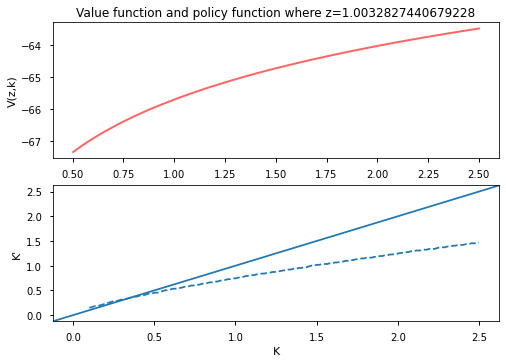

In [102]:
Model = VFI()

Model()


#### Analysis

- Concave value function (it preserves the concavity of the utility function)
- Concave policy function and steady state around 0.23

## LQ Model

Now our state variables: $ x_t = \begin{bmatrix}  log(z_t) \\ \hat k_t\end{bmatrix}_{2x1}$ and control variables: $ u_t = \begin{bmatrix} \hat k_{t+1} \\ h_t \end{bmatrix}_{2x1}$.

Define: **steady state values** for state and control variables as: $ \bar x_t = \begin{bmatrix} log( z_{ss} )\\ \hat k_{ss}\end{bmatrix}_{2x1}$; $ \bar u_t = \begin{bmatrix} \hat k_{ss} \\ h_{ss} \end{bmatrix}_{2x1}$.

First of all, **the one-period return function** is the following:

$$r(x_t, u_t) = r(z_t, \hat k_t, \hat k_{t+1}, h_t) = log(\hat k_t^\alpha (exp(log(z_t)) h_t)^{1-\alpha} + (1-\delta)\hat k_t - \hat \gamma k_{t+1}) + \psi log(1 - h_t)$$

Now, define:  **normalized around steady state (including constant 1 to state variables to incorporate $r(\bar x, \bar u)$)**:

state variables as: $ \tilde x_t = \begin{bmatrix} 1 \\ log(z_t) - log(z_{ss}) \\ \hat k_t - k_{ss}\end{bmatrix}_{3x1} =  x_t - \bar x\;\;\;$; and the control variables as: $ \tilde u_t = \begin{bmatrix} \hat k_{t+1} - k_{ss} \\ h_t - h_{ss} \end{bmatrix}_{2x1}\; = u_t - \bar u$.

Then second order Taylor approximation of the one-period return function around the steady state, $\bar x, \bar u$ is:

$$r(x_t, u_t)  \simeq \dfrac{1}{2} \begin{bmatrix} \tilde x_t & \tilde u_t\end{bmatrix}_{1x5} \begin{bmatrix} 2 r(\bar x, \bar u) & J_r^T \\ J_r & H_r\end{bmatrix}_{5x5} \begin{bmatrix} \tilde x_t \\ \tilde u_t\end{bmatrix}_{5x1}$$

Where $J_r$ is Jacobian of the return function at the steady state, $H_r$ is the Hessian of the return function at the steady state, $r(\bar x, \bar u)$ is the return function evaluated at the steady state.

Then we can also write down the same equation as:

$$r(x_t, u_t) \simeq \begin{bmatrix} \tilde x_t & \tilde u_t\end{bmatrix}_{1x5} \begin{bmatrix} Q_{3x3} & W_{3x2} \\ W^T_{2x3} & R_{2x2}\end{bmatrix}_{5x5} \begin{bmatrix} \tilde x_t \\ \tilde u_t\end{bmatrix}_{5x1}$$

**(don't forget to multiply the middle matrix with $\dfrac{1}{2}$)**

Thus, we have found Q, W and R.

Now, let's look at the law of motion to find A, B and C:

$$\tilde x_{t+1} = A \tilde x_t + B \tilde u_t + C \epsilon_{t+1}$$

$$\begin{bmatrix}1\\ log(\tilde z_{t+1}) \\ \tilde k_{t+1}  \end{bmatrix}_{3x1} = \underbrace{\begin{bmatrix} 1 & 0 & 0 \\ 0 & \rho & 0 \\ 0 & 0 & 0 \end{bmatrix}_{3x3}}_{A}\begin{bmatrix} 1\\ log(\tilde z_t)\\ \tilde  k_t\end{bmatrix}_{3x1} + \underbrace{\begin{bmatrix}0 & 0\\0&0\\ 1& 0 \end{bmatrix}_{3x2}}_{B}\begin{bmatrix}\tilde k_{t+1} \\ \tilde h_t\end{bmatrix} + \underbrace{\begin{bmatrix} 0\\1\\0\end{bmatrix}_{3x1}}_{C}\epsilon_{t+1}$$

After finding A, B, C, R, Q, W the original problem can be written as the following LQ problem:

$$\max_{\{\tilde u_t, \tilde x_{t+1}\}} \mathbb{E} \sum_{t=0}^{\infty} \hat \beta^t [ \tilde x_t^T Q \tilde x_t + \tilde u_t^T R \tilde u_t + 2 \tilde x_t^T W \tilde u_t]$$
$$s.t.\;\;\; \tilde x_{t+1} = A \tilde x_t + B \tilde u_t + C \epsilon_{t+1}$$

In order to get rid of the discount factor $\hat \beta^t$ and the cross product $2 \tilde x_t^T W \tilde u_t$, we will re-define our variables as:

$$\hat x_t = \hat \beta^{\frac{t}{2}}\tilde x_t $$
$$\hat u_t = \hat \beta^{\frac{t}{2}}[\tilde u_t + R^{-1}W^T\tilde x_t] $$
$$\hat \epsilon_{t+1} = \hat \beta^{\frac{t}{2}}\epsilon_{t+1} $$
$$\hat A = \sqrt{\hat \beta} [A - BR^{-1}W^T] $$
$$\hat B = \sqrt{\hat \beta} B $$
$$\hat Q = Q - WR^{-1}W^T $$
$$\hat C = \sqrt{\hat \beta}C $$

Then the problem becomes:

$$\max_{\{\hat u_t, \hat x_{t+1}\}} \mathbb{E} \sum_{t=0}^{\infty} [ \hat x_t^T \hat Q \hat x_t + \hat u_t^T R \hat u_t ]$$
$$s.t.\;\;\; \hat x_{t+1} = \hat A \hat x_t + \hat B \hat u_t + \hat C \hat \epsilon_{t+1}$$

## Method 2: Solving by Using Ricatti Equation

The problem above can be written in functional form as:


$$V(\hat x) = \max_{\{\hat u, \hat x_{+1}\}}  \hat x' \hat Q \hat x + \hat u' R \hat u + \mathbb{E}[V(\hat x_{+1})]$$
$$s.t.\;\;\; \hat x_{+1} = \hat A \hat x + \hat B \hat u + \hat C \hat \epsilon_{+1}$$

We will solve this dynamic problem by guess and verify. Guess the value function as: $V_t(\hat x) = \hat x' P \hat x + \hat \beta^t c$

Then:

$$V_t(\hat x) = \max_{\{\hat u, \hat x_{+1}\}}  \hat x' \hat Q \hat x + \hat u' R \hat u + \mathbb{E}[\hat x_{+1}' P \hat x_{+1}] + \hat \beta^{t+1} c$$
$$s.t.\;\;\; \hat x_{+1} = \hat A \hat x + \hat B \hat u + \hat C \hat \epsilon_{+1}$$

Substitute the resource constraint into the objective function and we get:

$$V_t(\hat x) = \max_{\{\hat u\}}  \hat x' \hat Q \hat x + \hat u' R \hat u + \mathbb{E}[(\hat A \hat x + \hat B \hat u + \hat C \hat \epsilon_{+1})' P (\hat A \hat x + \hat B \hat u + \hat C \hat \epsilon_{+1})] + \hat \beta^{t+1} c$$

$$= \max_{\{\hat u\}}  \hat x' \hat Q \hat x + \hat u' R \hat u  \hat x\hat A'P\hat A \hat x+ 2 \hat x \hat A' P \hat B \hat u + \hat u' \hat B' P \hat B \hat u + \mathbb{E}[\hat \epsilon^2_{+1} ]\hat C' P \hat C + \hat \beta^{t+1} c $$

$$= \max_{\{\hat u\}}  \hat x' (\hat Q + \hat A' P \hat A) \hat x + \hat u' (R + \hat B' P \hat B) \hat u  + 2 \hat x\hat A'P\hat B \hat u + \mathbb{E}[\hat \epsilon^2_{+1} ]\hat C' P \hat C + \hat \beta^{t+1} c$$

FOC wrt $\hat u$ is:

$$2[R + \hat B' P \hat B ]\hat u + 2 \hat B' P \hat A \hat x = 0$$
$$\hat u = - \underbrace{[(R + \hat B' P \hat B )^{-1} \hat B' P \hat A]}_{F} \hat x$$

Notice that F depends on P. So we need to find P. How to find it? Replace your LHS with your guess as well and substitute $\hat u = -F\hat x$ in the maximization problem on the RHS:

$$\hat x' P \hat x + \hat \beta^t c = \hat x'(\hat Q + \hat A' P \hat A)\hat x + \hat x' F' (R + \hat B' P \hat B)F \hat x - 2 \hat x' \hat A' P \hat B F \hat x + \mathbb{E} [\hat \epsilon_{+1}^2]\hat C' P \hat C + \hat \beta^{t+1} c $$

$$\hat x' P \hat x + \hat \beta^t c = \hat x'[(\hat Q + \hat A' P \hat A) + F' (R + \hat B' P \hat B)F - 2 \hat A' P \hat B F ] \hat x + \mathbb{E} [\hat \epsilon_{+1}^2]\hat C' P \hat C + \hat \beta^{t+1} c$$


**(Note that we can write down this equation with the $\sim$ notation of x as the following:)**
**$$\tilde x' P \tilde x + c = \tilde x'[(\hat Q + \hat A' P \hat A) + F' (R + \hat B' P \hat B)F - 2 \hat A' P \hat B F ] \tilde x + \mathbb{E} [ \epsilon_{+1}^2]\hat C' P \hat C + \hat \beta c \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; (*)$$**


From the last equation, we can find P as:

$$P = (\hat Q + \hat A' P \hat A) + F' (R + \hat B' P \hat B)F - 2 \hat A' P \hat B F$$


Substitute F: 
$$P = (\hat Q + \hat A' P \hat A) - \hat A' P \hat B F$$
$$P = (\hat Q + \hat A' P \hat A) - \hat A' P \hat B [(R + \hat B' P \hat B )^{-1} \hat B' P \hat A]$$

This is the Ricatti equation. We can iterate the last equation to find P.





### Summary

We can iterate the following iteration to get P:

$$P_{t+1} = (\hat Q + \hat A' P_t \hat A) - \hat A' P_t \hat B [(R + \hat B' P_t \hat B )^{-1} \hat B' P_t \hat A]$$

Then our F is:

$$F = (R + \hat B' P \hat B )^{-1} \hat B' P \hat A$$

Then our policy function is:

$$\hat u_t = -F \hat x_t$$

and our law of motion is:

$$\hat x_{t+1} = (\hat A - \hat B F)\hat x_t + \hat C \epsilon_{t+1}$$

After finding $\;\;\hat{}\;\;$ values, we can find $\sim$ values of $\tilde x_t, \tilde u_t$ by reverse transformation of the transformation we did to get rid of discount factor and cross product term. 

Now, to find the value function, we need to find c. To find it equate RHS of constant and LHS of constant in the equation **(*)**:

$$c = \mathbb{E}[\epsilon_{+1}^2]\hat C' P \hat C + \hat \beta c = \dfrac{\hat \beta}{1 - \hat \beta}\sigma^2 \hat C' P \hat C$$

After finding c as well, we can write down our value function:

$$V(\tilde x)= \tilde x' P \tilde x + c$$

#### Solution Steps

- Find steady states.
- Find Q, W, R by writing down the one period return function as quadratic function (by taking second order Taylor approximation). To do this, find Jacobian and Hessian at the steady state.
- Find A, B, C from the law of motion.
- Normalize (transform) your $\sim$ variables to get $\;\; \hat{} \;\;$ variables to get rid of discount factor and cross product.
- Iterate Ricatti equation to get P. Then get F as well.
- Reverse transform to get $\sim$ variables.

In [16]:
class Derivatives_at_SS:
    """This class is for generating Jacobian and Hessian matrix numerically at the steady state"""

    def __init__(self, f, s1, s2, d1, d2):
        self.f = f  # Objective function
        self.s1 = s1  # Steady state value of s1
        self.s2 = s2  # Steady state value of s2
        self.d1 = d1  # Steady state value of d1
        self.d2 = d2  # Steady state value of d2

    def Δs1(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(s1)*10e-4)
        return (f(s1+Δ, s2, d1, d2) - f(s1, s2, d1, d2)) / Δ

    def Δs2(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(s2)*10e-4)
        return (f(s1, s2+Δ, d1, d2) - f(s1, s2, d1, d2)) / Δ

    def Δd1(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(d1)*10e-4)
        return (f(s1, s2, d1+Δ, d2) - f(s1, s2, d1, d2)) / Δ

    def Δd2(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(d2)*10e-4)
        return (f(s1, s2, d1, d2+Δ) - f(s1, s2, d1, d2)) / Δ

    def Δs1s1(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(s1)*10e-4)
        μ = max(10e-8, abs(s1)*10e-4)
        derivative = (((f(s1+Δ+μ, s2, d1, d2) - f(s1+μ, s2, d1, d2))/Δ) -
                      ((f(s1+Δ, s2, d1, d2) - f(s1, s2, d1, d2))/Δ))/μ
        return derivative

    def Δs1s2(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(s1)*10e-4)
        μ = max(10e-8, abs(s2)*10e-4)
        derivative = (((f(s1+Δ, s2+μ, d1, d2) - f(s1, s2+μ, d1, d2))/Δ) -
                      ((f(s1+Δ, s2, d1, d2) - f(s1, s2, d1, d2))/Δ))/μ
        return derivative

    def Δs1d1(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(s1)*10e-4)
        μ = max(10e-8, abs(d1)*10e-4)
        derivative = (((f(s1+Δ, s2, d1+μ, d2) - f(s1, s2, d1+μ, d2))/Δ) -
                      ((f(s1+Δ, s2, d1, d2) - f(s1, s2, d1, d2))/Δ))/μ
        return derivative

    def Δs1d2(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(s1)*10e-4)
        μ = max(10e-8, abs(d2)*10e-4)
        derivative = (((f(s1+Δ, s2, d1, d2+μ) - f(s1, s2, d1, d2+μ))/Δ) -
                      ((f(s1+Δ, s2, d1, d2) - f(s1, s2, d1, d2))/Δ))/μ
        return derivative

    def Δs2s2(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(s2)*10e-4)
        μ = max(10e-8, abs(s2)*10e-4)
        derivative = (((f(s1, s2+Δ+μ, d1, d2) - f(s1, s2+μ, d1, d2))/Δ) -
                      ((f(s1, s2+Δ, d1, d2) - f(s1, s2, d1, d2))/Δ))/μ
        return derivative

    def Δs2d1(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(s2)*10e-4)
        μ = max(10e-8, abs(d1)*10e-4)
        derivative = (((f(s1, s2+Δ, d1+μ, d2) - f(s1, s2, d1+μ, d2))/Δ) -
                      ((f(s1, s2+Δ, d1, d2) - f(s1, s2, d1, d2))/Δ))/μ
        return derivative

    def Δs2d2(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(s2)*10e-4)
        μ = max(10e-8, abs(d2)*10e-4)
        derivative = (((f(s1, s2+Δ, d1, d2+μ) - f(s1, s2, d1, d2+μ))/Δ) -
                      ((f(s1, s2+Δ, d1, d2) - f(s1, s2, d1, d2))/Δ))/μ
        return derivative

    def Δd1d1(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(d1)*10e-4)
        μ = max(10e-8, abs(d1)*10e-4)
        derivative = (((f(s1, s2, d1+Δ+μ, d2) - f(s1, s2, d1+μ, d2))/Δ) -
                      ((f(s1, s2, d1+Δ, d2) - f(s1, s2, d1, d2))/Δ))/μ
        return derivative

    def Δd1d2(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(d1)*10e-4)
        μ = max(10e-8, abs(d2)*10e-4)
        derivative = (((f(s1, s2, d1+Δ, d2+μ) - f(s1, s2, d1, d2+μ))/Δ) -
                      ((f(s1, s2, d1+Δ, d2) - f(s1, s2, d1, d2))/Δ))/μ
        return derivative

    def Δd2d2(self):
        f, s1, s2, d1, d2 = self.f, self.s1, self.s2, self.d1, self.d2
        Δ = max(10e-8, abs(d2)*10e-4)
        μ = max(10e-8, abs(d2)*10e-4)
        derivative = (((f(s1, s2, d1, d2+Δ+μ) - f(s1, s2, d1, d2+μ))/Δ) -
                      ((f(s1, s2, d1, d2+Δ) - f(s1, s2, d1, d2))/Δ))/μ
        return derivative

    def Jacobian(self):
        # Jacobian at the steady state
        J = np.array([self.Δs1(), self.Δs2(), self.Δd1(),
                     self.Δd2()]).reshape((4, 1))
        return J

    def Hessian(self):
        H = np.array([[self.Δs1s1(), self.Δs1s2(), self.Δs1d1(), self.Δs1d2()],  # Hessian at the steady state
                      [self.Δs1s2(), self.Δs2s2(), self.Δs2d1(), self.Δs2d2()],
                      [self.Δs1d1(), self.Δs2d1(), self.Δd1d1(), self.Δd1d2()],
                      [self.Δs1d2(), self.Δs2d2(), self.Δd1d2(), self.Δd2d2()]])
        return H


In [83]:
class LQ:
    """Our LQ Model"""

    def __init__(self, p=0.9, δ=0.9, θ=0.7, β=0.95, γ_z=0.01, γ_n=0.01, ψ=0.5, tol=10e-4, max_iter=10000):
        self.p = p                       # \rho in AR(1) process in technology
        self.β = β                       # discount factor
        self.θ = θ                       # capital share
        self.δ = δ                       # depreciation rate of capital
        self.ψ = ψ                       # parameter for valuing leisure
        self.γ_z = γ_z                   # growth rate of capital
        self.γ_n = γ_n                   # growth rate of population

        self.β_hat = β * (1 + γ_n)       # Normalized beta
        self.γ_hat = (1 + γ_n) * (1 + γ_z)  # Normalized gamma

        self.max_iter = max_iter         # Maximum iteration
        self.iterations = 0              # Iteration number of the VFI process
        self.tol = tol  # Tolerance of convergence

        # Steady state values
        self.Λ = (((self.γ_hat/self.β_hat) - (1-δ))/θ)**(1/(1-θ))  # aux
        self.Θ = ((1-θ)*(self.Λ)**(-θ)) / \
            ((self.Λ)**(1-θ)+(1-δ-self.γ_hat))  # aux

        self.zss = 0  # z_ss
        self.hss = (1 + ψ/(self.Λ * self.Θ))**(-1)  # h_ss
        self.kss = ((1 - self.hss)/ψ) * self.Θ  # k_ss
        self.kpss = ((1 - self.hss)/ψ) * self.Θ  # k_ss

    def Ret(self, z, k, kp, h):
        """One-period return function"""
        return np.log( (k**(self.θ)) * (np.exp(z)*h)**(1 - self.θ) + (1-self.δ)*k - self.γ_hat * kp) + self.ψ * np.log(1 - h)

    def construct_Q(self):
        """Create Jacobian,Hessian matrices and return value at the steady state and create big matrix (to find R,Q,W) correspondingly"""
        self.H = Derivatives_at_SS(
            self.Ret, self.zss, self.kss, self.kpss, self.hss).Hessian()/2  # Hessian
        self.J = Derivatives_at_SS(
            self.Ret, self.zss, self.kss, self.kpss, self.hss).Jacobian()/2  # Jacobian
        self.Return = np.array(self.Ret(self.zss, self.kss, self.kpss,
                                        self.hss)).reshape((1, 1))  # Return at steady state

        first_row = np.concatenate([self.Return, self.J]).T
        rest_of_matrix = np.concatenate([self.J, self.H], axis=1)

        # Our big matrix to find Q,R,W
        self.big_matrix = np.concatenate([first_row, rest_of_matrix])

    def ABC_RQW(self):
        """Decomposes Big Matrix into R,Q,W and uses law of motinon to find A,B,C as well."""
        self.Q = self.big_matrix[0:3, 0:3]
        self.R = self.big_matrix[3:, 3:]
        self.W = self.big_matrix[0:3, 3:]

        self.A = np.array([[1, 0, 0],
                           [0, self.p, 0],
                           [0, 0, 0]])

        self.B = np.array([[0, 0],
                           [0, 0],
                           [1, 0]])

        self.C = np.array([[0],
                           [1],
                           [0]])

    def Normalize(self):
        """Normalizing"""
        self.A_tilde = np.sqrt(self.β_hat) * (self.A -
                                              self.B @ np.linalg.inv(self.R) @ self.W.T)

        self.B_tilde = np.sqrt(self.β_hat) * self.B

        self.Q_tilde = self.Q - (self.W @ np.linalg.inv(self.R) @ self.W.T)

    def convergence(self):
        self.construct_Q()
        self.ABC_RQW()
        self.Normalize()
        self.P_0 = np.array([[0, 0, 0],  # Initial guess of value function
                             [0, 0, 0],
                             [0, 0, 0]])

        self.P_1 = np.ones((3, 3))  # To be able to start iteration

        #P_0, P_1, Q, A, B, R = self.P_0, self.P_1, self.Q_tilde, self.A_tilde, self.B_tilde, self.R

        while np.max(np.abs(self.P_1 - self.P_0) > self.tol) and self.iterations < self.max_iter:
            self.P_0 = np.copy(self.P_1)
            self.P_1 = (self.Q_tilde + self.A_tilde.T @ self.P_0 @ self.A_tilde) - \
                self.A_tilde.T @ self.P_0 @ self.B_tilde @ (np.linalg.inv(self.R + self.B_tilde.T @
                                 self.P_0 @ self.B_tilde) @ self.B_tilde.T @ self.P_0 @ self.A_tilde)
            self.iterations += 1

        self.P = np.copy(self.P_1)
        self.F = (np.linalg.inv(self.R + self.B_tilde.T @ self.P_1 @ self.B_tilde) @ self.B_tilde.T @ self.P_1 @ self.A_tilde)

    def Graphics(self):
        self.convergence()
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        S1 = np.log(np.linspace(0.95, 1.05, 5))  # Technologies
        S2 = np.linspace(0.1, 0.30, 200)  # Capitals

        for s1 in range(len(S1)):
            values = []
            policy_values = []
            for s2 in range(len(S2)):
                v = np.matmul(np.matmul(np.matrix([1, (S1[s1]) - (self.zss), S2[s2] - self.kss]), self.P), np.matrix(
                    [1, (S1[s1]) - (self.zss), S2[s2] - self.kss]).T).item(0)
                values.append(v)
                k = - np.matmul(self.F + np.matmul(np.linalg.inv(self.R), self.W.T), (np.array(
                    [[1], [(S1[s1]) - (self.zss)], [S2[s2] - self.kss]]))).item(0) + self.kpss
                policy_values.append(k)

            ax[0].plot(S2, values, '--',label="z ={}".format(np.round(np.exp(S1[s1]), 2)))
            ax[0].set_xlabel('k')
            ax[0].set_ylabel('V(z,k)')
            ax[0].title.set_text('The graph of V(z,k)')
            ax[0].legend()

            ax[1].plot(S2, policy_values, '--',label="z ={}".format(np.round(np.exp(S1[s1]), 2)))
            ax[1].set_xlabel('k')
            ax[1].set_ylabel("k'")
            ax[1].title.set_text('The graph of optimal policy function')
            ax[1].axline((np.min(S2), np.min(S2)), (S2.max(), S2.max()))
            ax[1].legend()

        plt.show()

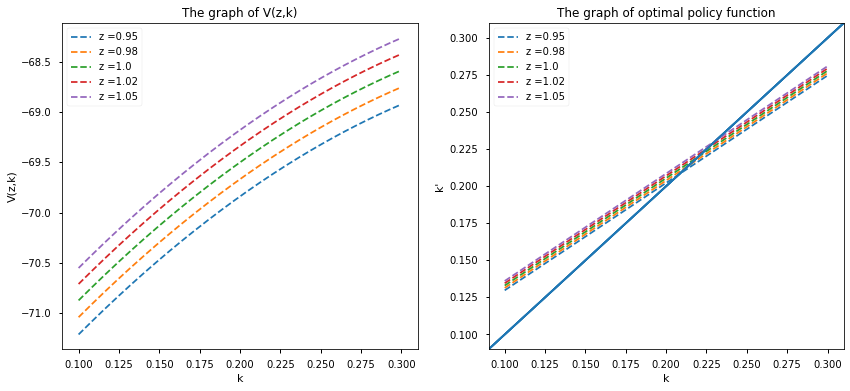

In [84]:
Model = LQ()
Model.convergence()

Model.Graphics()


In [52]:
print("The steady state level of capital is: ", np.round(Model.kss,2))

The steady state level of capital is:  0.22


#### Analysis

- As you can see the optimal policy function is consistent with the steady state level of capital. (i.e. when z = 1, the line hits 0.22 as it is supposed to)

- We have concave value function around the steady state.

- It is important to note that this LQ model (and Vaughan Model below) works well around the point that we are doing the Taylor approximation. Since we are taking the taylor approximation around the steady state, the model is consistent around the steady state. But if we widen the scope (i.e. if we widen the capital grid) then it becomes inconsistent.

## Method 3: Solving by using Vaughan's Method

This method can be used after getting rid of discount factor and cross product of the LQ model (i.e. after transformation). Recall that after transformation, our problem became (disregarding the stochastic part, since by certainity equivalence P does not change and here our goal is to find P):

$$\max_{\{\hat u_t, \hat x_{t+1}\}} \mathbb{E} \sum_{t=0}^{\infty} [ \hat x_t^T \hat Q \hat x_t + \hat u_t^T R \hat u_t ]$$
$$s.t.\;\;\; \hat x_{t+1} = \hat A \hat x_t + \hat B \hat u_t$$


Let $(2\lambda_{t+1})$ be the lagrange multiplier of the constraint and take FOC's. Then we get:

$$(\hat u_t) \;\;\; 2 R \hat u_t = -2 \hat B' \lambda_{t+1}$$
$$(\hat x_{t+1})\;\;\;2 \hat Q \hat x_{t+1} = 2 \lambda_{t+1} - 2 \hat A' \lambda_{t+2} $$
$$(2 \lambda_{t+1})\;\;\; \hat x_{t+1} = \hat A \hat x_t + \hat B \hat u_t$$

These system of equations can be reduced by lagging second equation by one period and substitute others:

$$\lambda_t = \hat Q \hat x_{t} + \hat A' \lambda_{t+1}$$
$$\hat x_{t+1} + \hat B R^{-1}\hat B \lambda_{t+1} = \hat A \hat x_t$$

If $\hat A$ is invertible, we can express this system as:

$$\lambda_t = \hat Q \hat x_{t} + \hat A' \lambda_{t+1}$$
$$\hat A^{-1} \hat x_{t+1} + \hat A^{-1} \hat B R^{-1}\hat B \lambda_{t+1} = \hat x_t$$

Then it becomes:

$$\lambda_t = \hat Q (\hat A^{-1} \hat x_{t+1} + \hat A^{-1} \hat B R^{-1}\hat B \lambda_{t+1}) + \hat A' \lambda_{t+1}$$
$$\Longrightarrow \lambda_t = \hat Q \hat A^{-1} \hat x_{t+1} + (\hat Q \hat A^{-1} \hat B R^{-1}\hat B  + \hat A') \lambda_{t+1}$$
$$\hat A^{-1} \hat x_{t+1} + \hat A^{-1} \hat B R^{-1}\hat B \lambda_{t+1} = \hat x_t$$

We can now form Hamiltonian Matrix as:

$$\begin{bmatrix} \hat x_t \\ \lambda_t \end{bmatrix} = \underbrace{\begin{bmatrix} \hat A^{-1} & \hat A^{-1}\hat B R^{-1}\hat B' \\ \hat Q \hat A^{-1} & \hat Q \hat A{-1} \hat B R^{-1} \hat B' + \hat A' \end{bmatrix}}_{\mathbb{H}} \begin{bmatrix}\hat x_{t+1} \\ \lambda_{t+1} \end{bmatrix}$$

$$\begin{bmatrix} \hat x_t \\ \lambda_t \end{bmatrix} = \mathbb{H} \begin{bmatrix} \hat x_{t+1} \\ \lambda_{t+1} \end{bmatrix}$$

Now decompose H in such a way that the eigenvalues which exceed unit value will be on the top half of eigenvalue matrix and the bottom half is the reciprocal of top: 

$$\mathbb{H} = V \Lambda V^{-1}$$

$$\mathbb{H} = \begin{bmatrix} V_{11} & V_{12}\\ V_{21} & V_{22}\end{bmatrix} \begin{bmatrix} \Lambda & 0 \\ 0 &  \Lambda^{-1}\end{bmatrix} \begin{bmatrix} V_{11} & V_{12}\\ V_{21} & V_{22}\end{bmatrix}^{-1} $$

Then, we have:

$$P = V_{21}V_{11}^{-1}$$

After finding P, we can find F as how we have found in Ricatti case:

$$F = (R + \hat B' P \hat B )^{-1} \hat B' P \hat A$$

Then our policy function is:

$$\hat u_t = -F \hat x_t$$

#### Solution Steps

- Find steady states.
- Find Q, W, R by writing down the one period return function as quadratic function (by taking second order Taylor approximation). To do this, find Jacobian and Hessian at the steady state.
- Find A, B, C from the law of motion.
- Normalize (transform) your $\sim$ variables to get $\;\; \hat{} \;\;$ variables to get rid of discount factor and cross product.
- Form Hamiltonian
- Decompose Hamiltonian in such a way that the eigenvalues which exceed unit value will be on the top half of eigenvalue matrix and the bottom half is the reciprocal of top.
- Compute P as $P = V_{21}V_{11}^{-1}$. Then compute F 
- Reverse transform to get $\sim$ variables.

In [81]:
class Vaughan:
    """Our Vaughan Model"""

    def __init__(self, p=0.9, δ=0.9, θ=0.7, β=0.95, γ_z=0.01, γ_n=0.01, ψ=0.5):
        self.p = p                       # \rho in AR(1) process in technology
        self.β = β                       # discount factor
        self.θ = θ                       # capital share
        self.δ = δ                       # depreciation rate of capital
        self.ψ = ψ                       # parameter for valuing leisure
        self.γ_z = γ_z                   # growth rate of capital
        self.γ_n = γ_n                   # growth rate of population
        self.e = np.exp(1)

        self.β_hat = β * (1 + γ_n)       # Normalized beta
        self.γ_hat = (1 + γ_n) * (1 + γ_z)  # Normalized gamma

        # Steady state values
        self.Λ = (((self.γ_hat/self.β_hat) - (1-δ))/θ)**(1/(1-θ))  # aux
        self.Θ = ((1-θ)*(self.Λ)**(-θ)) / \
            ((self.Λ)**(1-θ)+(1-δ-self.γ_hat))  # aux

       
        self.zss = 0  # z_ss
        self.hss = (1 + ψ/(self.Λ * self.Θ))**(-1)  # h_ss
        self.kss = ((1 - self.hss)/ψ) * self.Θ  # k_ss
        self.kpss = ((1 - self.hss)/ψ) * self.Θ  # k_ss

    def Ret(self, z, k, kp, h):
        """One-period return function"""
        return np.log( (k**(self.θ)) * (np.exp(z)*h)**(1 - self.θ) + (1-self.δ)*k - self.γ_hat * kp) + self.ψ * np.log(1 - h)

    def construct_Q(self):
        """Create Jacobian,Hessian matrices and return value at the steady state and create big matrix (to find R,Q,W) correspondingly"""
        self.H = Derivatives_at_SS(
            self.Ret, self.zss, self.kss, self.kpss, self.hss).Hessian()/2  # Hessian
        self.J = Derivatives_at_SS(
            self.Ret, self.zss, self.kss, self.kpss, self.hss).Jacobian()/2  # Jacobian
        self.Return = np.array(self.Ret(self.zss, self.kss, self.kpss,
                                        self.hss)).reshape((1, 1))  # Return at steady state

        first_row = np.concatenate([self.Return, self.J]).T
        rest_of_matrix = np.concatenate([self.J, self.H], axis=1)

        # Our big matrix to find Q,R,W
        self.big_matrix = np.concatenate([first_row, rest_of_matrix])

    def ABC_RQW(self):
        """Decomposes Big Matrix into R,Q,W and uses law of motinon to find A,B,C as well."""
        self.Q = self.big_matrix[0:3, 0:3]
        self.R = self.big_matrix[3:, 3:]
        self.W = self.big_matrix[0:3, 3:]

        self.A = np.array([[1, 0, 0],
                           [0, self.p, 0],
                           [0, 0, 0]])

        self.B = np.array([[0, 0],
                           [0, 0],
                           [1, 0]])

        self.C = np.array([[0],
                           [1],
                           [0]])

    def Normalize(self):
        """Normalizing"""
        self.A_tilde = np.sqrt(self.β_hat) * (self.A -
                                              self.B @ np.linalg.inv(self.R) @ self.W.T)

        self.B_tilde = np.sqrt(self.β_hat) * self.B

        self.Q_tilde = self.Q - (self.W @ np.linalg.inv(self.R) @ self.W.T)

    def Hamilton(self):
        """Defining the Hamiltonian"""
        A_tilde, B_tilde, Q_tilde = self.A_tilde, self.B_tilde, self.Q_tilde

        h11 = np.linalg.inv(self.A_tilde)
        h12 = np.linalg.inv(
            self.A_tilde) @ self.B_tilde @ np.linalg.inv(self.R) @ self.B_tilde.T
        h21 = self.Q_tilde @ np.linalg.inv(self.A_tilde)
        h22 = self.Q_tilde @ np.linalg.inv(self.A_tilde) @ self.B_tilde @ np.linalg.inv(
            self.R) @ self.B_tilde.T + self.A_tilde.T

        self.Hamiltonian = np.block([[h11, h12], [h21, h22]])

    def decomposition(self):
        """Decompose Hamiltonian matrix and order the eigenvalues and eigenvectors"""
        h = self.Hamiltonian.shape[0] // 2  # Midpoint

        val, vec = np.linalg.eig(self.Hamiltonian)

        idx_sorted = np.argsort(val)[::-1]  # Order in descending order
        # Reverse the order of the second half
        idx_sorted[h:] = idx_sorted[h:][::-1]

        self.Λ, self.V = np.diag(val[idx_sorted]), vec[:, idx_sorted]

    def solving_P_and_F(self):
        """Get P and F"""
        self.construct_Q()
        self.ABC_RQW()
        self.Normalize()
        self.Hamilton()
        self.decomposition()

        h = self.Hamiltonian.shape[0] // 2
        self.V11, self.V21 = self.V[0:h, 0:h], self.V[h:, 0:h]

        self.P = self.V21 @ np.linalg.inv(self.V11)
        self.F = (np.linalg.inv(self.R + self.B_tilde.T @ self.P @
                  self.B_tilde) @ self.B_tilde.T @ self.P @ self.A_tilde)

    def Graphics(self):
        self.solving_P_and_F()
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        S1 = np.log(np.linspace(0.95, 1.05, 5)) # Technologies
        S2 = np.linspace(0.1, 0.30, 200)  # Capitals

        for s1 in range(len(S1)):
            values = []
            policy_values = []
            for s2 in range(len(S2)):
                v = np.matmul(np.matmul(np.matrix([1, (S1[s1]) - (self.zss), S2[s2] - self.kss]), self.P), np.matrix(
                    [1, (S1[s1]) - (self.zss), S2[s2] - self.kss]).T).item(0)
                values.append(v)
                k = - np.matmul(self.F + np.matmul(np.linalg.inv(self.R), self.W.T), (np.array(
                    [[1], [S1[s1] - self.zss], [S2[s2] - self.kss]]))).item(0) + self.kpss
                policy_values.append(k)

            ax[0].plot(S2, values, '--',label="z ={}".format(np.round(np.exp(S1[s1]), 2)))
            ax[0].set_xlabel('k')
            ax[0].set_ylabel('V(z,k)')
            ax[0].title.set_text('The graph of V(z,k)')
            ax[0].legend()

            ax[1].plot(S2, policy_values, '--', label="z ={}".format(np.round(np.exp(S1[s1]), 2)))
            ax[1].set_xlabel('k')
            ax[1].set_ylabel("k'")
            ax[1].title.set_text('The graph of optimal policy function')
        ax[1].axline((np.min(S2), np.min(S2)), (S2.max(), S2.max()), label="K =K' line")
        ax[1].legend()

        plt.show()


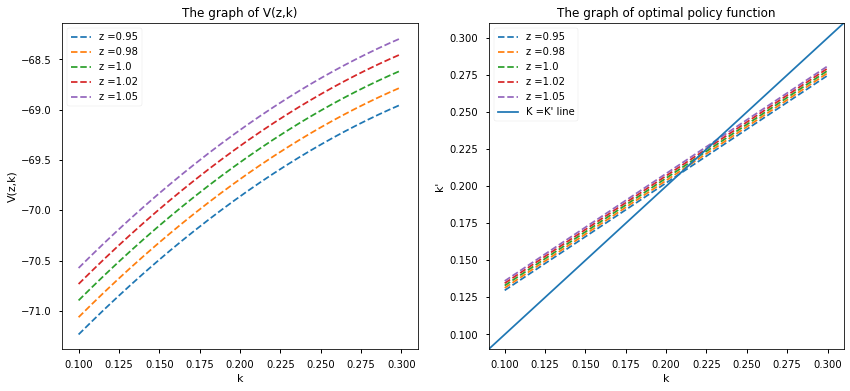

In [82]:
Model_vaughan = Vaughan()

Model_vaughan.Graphics()


##### Analysis

- We have the exact same answer as the Ricatti equation model. Thus same analysis holds here.

## Side Quest 1: Solving by Using Consumpiton and Leisure

(I'm going to use LQ Method to solve this problem)

Now let's do the same model with using consumption and leisure being control variables.

Now the state variable is: $x_t = \begin{bmatrix} 1 \\ log(z_t) \\ \hat k_t \end{bmatrix}$, control variable is: $u_t = \begin{bmatrix} \hat c_t \\ l_t \end{bmatrix}$ and the problem is:


$$\max_{\hat{c_{t}}, l_t}\mathbb{E}\sum_{t=0}^{\infty} \hat{\beta}^t[log(\hat c_t) + \psi log(l_t) + tlog(1+\gamma_z)]$$

$$s.t. \hat{\beta} = \beta (1+\gamma_n),\;\; \hat{\gamma} = (1+\gamma_n)(1+\gamma_z)$$
$$\hat c_t = \hat{k_t}^\alpha (exp(log(z_t))(1-l_t))^{1-\alpha} + (1-\delta)\hat{k_t} - \hat{\gamma}\hat{k_{t+1}}$$

We can get rid of $tlog(1+\gamma_z)$ part because it won't affect decision. and simplier version of the model is the following:

$$\max_{\hat{c_{t}}, l_t}\mathbb{E}\sum_{t=0}^{\infty} \hat{\beta}^t[log(\hat c_t) + \psi log(l_t)]$$

$$s.t. \hat{\beta} = \beta (1+\gamma_n),\;\; \hat{\gamma} = (1+\gamma_n)(1+\gamma_z)$$
$$\hat c_t = \hat{k_t}^\alpha (exp(log(z_t))(1-l_t))^{1-\alpha} + (1-\delta)\hat{k_t} - \hat{\gamma}\hat{k_{t+1}}$$

Now, the return function is the following:


$$r(u_t, x_t) = log(\hat c_t) + \psi log(l_t)$$

First of all, we have found the steady state for capital and hours above. So we can easily calculate the steady state values of consumption and labor: (remember $z_{ss} = 1$ again):

$$(log(z_{ss}),c_{ss}, l_{ss}) = (0, (k_{ss}^\alpha (z_{ss}h_{ss})^{1-\alpha} + (1-\delta)k_{ss} - \hat \gamma k_{ss}), 1 - h_{ss})$$

$$\text{where, } (h_{ss}, k_{ss}) = ([1 + \dfrac{\psi}{\Lambda \Theta}]^{-1}, \dfrac{1 - h_{ss}}{\psi} \Theta)$$

$$\text{where, } \Lambda = (\dfrac{\frac{\hat{\gamma}}{\hat{\beta}} - (1-\delta)}{\alpha})^{\frac{1}{1-\alpha}}, \Theta = \dfrac{(1-\alpha)\Lambda^{-1}}{\Lambda^{1-\alpha}+(1-\delta - \hat{\gamma})}$$

We can find find R,Q,W by taking second order Taylor approximation of the return function:

Define:  **difference from the steady state variables**:

state variables as: $ \tilde x_t = \begin{bmatrix} 1 \\ log(z_t) - log(z_{ss}) \\ \hat k_t - k_{ss}\end{bmatrix}_{3x1} =  x_t - \bar x\;\;\;$; and the control variables as: $ \tilde u_t = \begin{bmatrix} \hat c_{t} - c_{ss} \\ l_t - l_{ss} \end{bmatrix}_{2x1}\; = u_t - \bar u$.

Then second order Taylor approximation of the one-period return function around the steady state, $\bar x, \bar u$ is:

$$r(x_t, u_t)  \simeq \dfrac{1}{2} \begin{bmatrix} \tilde x_t & \tilde u_t\end{bmatrix}_{1x5} \begin{bmatrix} 2 r(\bar x, \bar u) & J_r^T \\ J_r & H_r\end{bmatrix}_{5x5} \begin{bmatrix} \tilde x_t \\ \tilde u_t\end{bmatrix}_{5x1}$$

Where $J_r$ is Jacobian of the return function at the steady state, $H_r$ is the Hessian of the return function at the steady state, $r(\bar x, \bar u)$ is the return function evaluated at the steady state.

Then we can also write down the same equation as:

$$r(x_t, u_t) \simeq \begin{bmatrix} \tilde x_t & \tilde u_t\end{bmatrix}_{1x5} \begin{bmatrix} Q_{3x3} & W_{3x2} \\ W^T_{2x3} & R_{2x2}\end{bmatrix}_{5x5} \begin{bmatrix} \tilde x_t \\ \tilde u_t\end{bmatrix}_{5x1}$$

So far so good.

Now here is the tricky part: How can we find A,B,C's? Remember that in the LQ model, the constraint should be linear. But our constraint is:

$$ x_{t+1}(\hat k_{t+1}) = \dfrac{1}{\hat \gamma}[\hat{k_t}^\alpha (exp(log(z_t))(1-l_t))^{1-\alpha} + (1-\delta)\hat{k_t} -\hat c_t]$$

i.e. $x_{t+1}$'s $\hat k_{t+1}$ variable is not linearly related to $x_t$'s $\hat k_t, z_t$ and $u_t$'s $l_t$. What should we do now? 

Answer: Take first order approximation of the this law of motion of capital in steady state! So that we can linearize the production function and that allows us to have a linear constraint. Then we can easily define the A,B,C matrices.

Remember, the variables of this law of motion is $c_t,l_t,z_t,k_t$. You need to take jacobian wrt these variables.

**Solution Steps:**
- First calculate steady state values (use the steady state values that you found above)
- Take the second order Taylor approximation of the return function to get R,Q,W
- Take first order Taylor approximation of the production function to make the constraint linear. Then find A,B,C matrices.
- Do the Ricatti iteration to find P and correspondingly F

In [85]:
class LQ_consumption_leisure:
    """Our LQ Model"""

    def __init__(self, p=0.9, δ=0.9, θ=0.7, β=0.95, γ_z=0.01, γ_n=0.01, ψ=0.5, tol=10e-5, max_iter=10000):
        self.p = p                       # \rho in AR(1) process in technology
        self.β = β                       # discount factor
        self.θ = θ                       # capital share
        self.δ = δ                       # depreciation rate of capital
        self.ψ = ψ                       # parameter for valuing leisure
        self.γ_z = γ_z                   # growth rate of capital
        self.γ_n = γ_n                   # growth rate of population

        self.β_hat = β * (1 + γ_n)       # Normalized beta
        self.γ_hat = (1 + γ_n) * (1 + γ_z)  # Normalized gamma

        self.max_iter = max_iter         # Maximum iteration
        self.iterations = 0              # Iteration number of the VFI process
        self.tol = tol  # Tolerance of convergence
        
        # Steady state values
        self.Λ = (((self.γ_hat/self.β_hat) - (1-δ))/θ)**(1/(1-θ))  # aux
        self.Θ = ((1-θ)*(self.Λ)**(-θ)) / \
            ((self.Λ)**(1-θ)+(1-δ-self.γ_hat))  # aux

        self.z_ss = 0  # z_ss
        self.h_ss = (1 + ψ/(self.Λ * self.Θ))**(-1)  # h_ss
        self.k_ss = ((1 - self.h_ss)/ψ) * self.Θ  # k_ss
        self.l_ss = 1 - self.h_ss
        self.c_ss = (self.k_ss ** θ) * ((1-self.l_ss)**(1-θ)) + (1-δ-self.γ_hat)* self.k_ss

    def law_of_k(self, z, k, c, l):
        return ((k**self.θ)* ((np.exp(z)* (1-l))**(1-self.θ)) + (1-self.δ)*k - c)/self.γ_hat

    def Δz(self):
        f, z_ss, k_ss, c_ss, l_ss = self.law_of_k, self.z_ss, self.k_ss, self.c_ss, self.l_ss
        Δ = max(10e-8, abs(z_ss)*10e-4)
        return (f(z_ss+Δ, k_ss, l_ss, c_ss) - f(z_ss, k_ss, l_ss, c_ss)) / Δ

    def Δk(self):
        f, z_ss, k_ss, c_ss, l_ss = self.law_of_k, self.z_ss, self.k_ss, self.c_ss, self.l_ss
        Δ = max(10e-8, abs(k_ss)*10e-4)
        return (f(z_ss, k_ss+Δ, c_ss, l_ss) - f(z_ss, k_ss, c_ss, l_ss)) / Δ

    def Δl(self):
        f, z_ss, k_ss, c_ss, l_ss = self.law_of_k, self.z_ss, self.k_ss, self.c_ss, self.l_ss
        Δ = max(10e-8, abs(l_ss)*10e-4)
        return (f(z_ss, k_ss, l_ss+Δ, c_ss) - f(z_ss, k_ss, l_ss, c_ss)) / Δ
    
    def Δc(self):
        f, z_ss, k_ss, c_ss, l_ss = self.law_of_k, self.z_ss, self.k_ss, self.c_ss, self.l_ss
        Δ = max(10e-8, abs(c_ss)*10e-4)
        return (f(z_ss, k_ss, l_ss,c_ss+Δ) - f(z_ss, k_ss, l_ss, c_ss)) / Δ

    def Ret(self, z, k, c, l):
        """One-period return function"""
        return np.log(c) + self.ψ * np.log(l) + 0*z + 0*k

    def construct_Q(self):
        """Create Jacobian,Hessian matrices and return value at the steady state and create big matrix (to find R,Q,W) correspondingly"""
        self.H = Derivatives_at_SS(
            self.Ret, self.z_ss, self.k_ss, self.c_ss, self.l_ss).Hessian()/2  # Hessian
        self.J = Derivatives_at_SS(
            self.Ret, self.z_ss, self.k_ss, self.c_ss, self.l_ss).Jacobian()/2  # Jacobian
        self.Return = np.array(self.Ret(self.z_ss, self.k_ss, self.c_ss,
                                        self.l_ss)).reshape((1, 1))  # Return at steady state

        first_row = np.concatenate([self.Return, self.J]).T
        rest_of_matrix = np.concatenate([self.J, self.H], axis=1)

        # Our big matrix to find Q,R,W
        self.big_matrix = np.concatenate([first_row, rest_of_matrix])

    def ABC_RQW(self):
        """Decomposes Big Matrix into R,Q,W and uses law of motinon to find A,B,C as well."""
        self.Q = self.big_matrix[0:3, 0:3]
        self.R = self.big_matrix[3:, 3:]
        self.W = self.big_matrix[0:3, 3:]

        self.A = np.array([[1, 0, 0],
                           [0, self.p, 0],
                           [self.law_of_k(self.z_ss,self.k_ss, self.c_ss, self.l_ss) -\
                             (self.k_ss * self.Δk() + self.z_ss * self.Δz() + self.c_ss * self.Δc() + self.l_ss * self.Δl()),\
                                 self.Δz(), self.Δk()]])

        self.B = np.array([[0, 0],
                           [0, 0],
                           [self.Δc(), self.Δl()],  
                           ])

        self.C = np.array([[0],
                           [1],
                           [0]])

    def Normalize(self):
        """Normalizing"""
        self.A_tilde = np.sqrt(self.β_hat) * (self.A -
                                              self.B @ np.linalg.inv(self.R) @ self.W.T)

        self.B_tilde = np.sqrt(self.β_hat) * self.B

        self.Q_tilde = self.Q - (self.W @ np.linalg.inv(self.R) @ self.W.T)

    def convergence(self):
        self.construct_Q()
        self.ABC_RQW()
        self.Normalize()
        self.P_0 = np.zeros((3,3))

        self.P_1 = -np.ones((3, 3))  # To be able to start iteration

        #P_0, P_1, Q, A, B, R = self.P_0, self.P_1, self.Q_tilde, self.A_tilde, self.B_tilde, self.R

        while np.max(np.abs(self.P_1 - self.P_0) > self.tol) and self.iterations < self.max_iter:
            self.P_0 = np.copy(self.P_1)
            self.P_1 = (self.Q_tilde + self.A_tilde.T @ self.P_0 @ self.A_tilde) - \
                self.A_tilde.T @ self.P_0 @ self.B_tilde @ (np.linalg.inv(self.R + self.B_tilde.T @
                                 self.P_0 @ self.B_tilde) @ self.B_tilde.T @ self.P_0 @ self.A_tilde)
            self.iterations += 1

        self.P = np.copy(self.P_1)
        self.F = (np.linalg.inv(self.R + self.B_tilde.T @ self.P_1 @ self.B_tilde) @ self.B_tilde.T @ self.P_1 @ self.A_tilde)

    def Graphics(self):
        self.convergence()
        fig, ax = plt.subplots(figsize=(8, 6))

        S1 = np.log(np.linspace(0.95, 1.05, 5))  # Technologies
        S2 = np.linspace(0.12, 0.30, 200)  # Capitals

        for s1 in range(len(S1)):
            values = []
            policy_values = []
            for s2 in range(len(S2)):
                v = np.matmul(np.matmul(np.matrix([1, (S1[s1]) - (self.z_ss), S2[s2] - self.k_ss]), self.P), np.matrix(
                    [1, (S1[s1]) - (self.z_ss), S2[s2] - self.k_ss]).T).item(0)
                values.append(v)
                c = - np.matmul(self.F + np.matmul(np.linalg.inv(self.R), self.W.T), (np.array(
                    [[1], [(S1[s1]) - (self.z_ss)], [S2[s2] - self.k_ss]]))).item(0) + self.c_ss
                policy_values.append(c)

            ax.plot(S2, values, '--',label="z ={}".format(np.round(np.exp(S1[s1]), 2)))
            ax.set_xlabel('k')
            ax.set_ylabel('V(z,k)')
            ax.title.set_text('The graph of V(z,k) around the steady state')
            ax.legend()
        plt.show()

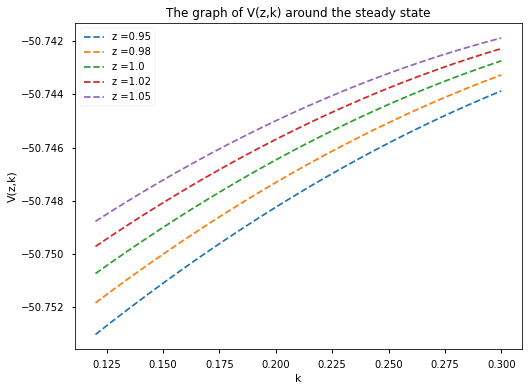

In [86]:
M = LQ_consumption_leisure()
M.Graphics()

#### Analysis

- The value shifted a little bit above. I don't understand why it is the case but it must be something about taylor approximations' residuals.
- Again we have concave value function around the steady state
- But since we are doing double approximation (first order Taylor approximation to find A,B,C and second order Taylor approximation to find Q,R,W) the model will be consistent when it is very near to the steady state.

In [94]:
print('The steady state of this problem given the parameters are:')
print(r'C_ss = {}'.format(M.c_ss))
print('K_ss = {}'.format(M.k_ss))
print('l_ss = {}'.format(M.l_ss))
print('h_ss = {}'.format(M.h_ss))



The steady state of this problem given the parameters are:
C_ss = 0.10136285429699463
K_ss = 0.2223650573344794
l_ss = 0.3557347528292223
h_ss = 0.6442652471707777


## Side Quest 2: Solving by Using Only Capital Today and Tomorrow

We would have the same steady state values for z and k.

Now we will use FOC's of the original problem and solve for h and substitute the solution of h into the return function.

In this case the state variables are the same: $ x_t = \begin{bmatrix}  log(z_t) \\ \hat k_t\end{bmatrix}_{2x1}$ and control variables: $ u_t = \begin{bmatrix} \hat k_{t+1} \end{bmatrix}_{1x1}$.

**the one-period return function** is the following:

$$r(x_t, u_t) = r(z_t, \hat k_t, \hat k_{t+1}) = log(\hat k_t^\alpha (exp(log(z_t)) h_t)^{1-\alpha} + (1-\delta)\hat k_t - \hat \gamma k_{t+1}) + \psi log(1 - h_t), \text{(where h is solved from FOC equations)}$$

Now, define:  **normalized around steady state (including constant 1 to state variables to incorporate $r(\bar x, \bar u)$)**:

state variables as: $ \tilde x_t = \begin{bmatrix} 1 \\ log(z_t) - log(z_{ss}) \\ \hat k_t - k_{ss}\end{bmatrix}_{3x1} =  x_t - \bar x\;\;\;$; and the control variables as: $ \tilde u_t = \begin{bmatrix} \hat k_{t+1} - k_{ss} \end{bmatrix}_{1x1}\; = u_t - \bar u$.

Then second order Taylor approximation of the one-period return function around the steady state, $\bar x, \bar u$ is:

$$r(x_t, u_t)  \simeq \dfrac{1}{2} \begin{bmatrix} \tilde x_t & \tilde u_t\end{bmatrix}_{1x4} \begin{bmatrix} 2 r(\bar x, \bar u) & J_r^T \\ J_r & H_r\end{bmatrix}_{4x4} \begin{bmatrix} \tilde x_t \\ \tilde u_t\end{bmatrix}_{4x1}$$

Where $J_r$ is Jacobian of the return function at the steady state, $H_r$ is the Hessian of the return function at the steady state, $r(\bar x, \bar u)$ is the return function evaluated at the steady state.

Then we can also write down the same equation as:

$$r(x_t, u_t) \simeq \begin{bmatrix} \tilde x_t & \tilde u_t\end{bmatrix}_{1x4} \begin{bmatrix} Q_{3x3} & W_{3x1} \\ W^T_{1x3} & R_{1x1}\end{bmatrix}_{4x4} \begin{bmatrix} \tilde x_t \\ \tilde u_t\end{bmatrix}_{4x1}$$

**(don't forget to multiply the middle matrix with $\dfrac{1}{2}$)**

Thus, we have found Q, W and R.

Now, let's look at the law of motion to find A, B and C:

$$\tilde x_{t+1} = A \tilde x_t + B \tilde u_t + C \epsilon_{t+1}$$

$$\begin{bmatrix}1\\ log(\tilde z_{t+1}) \\ \tilde k_{t+1}  \end{bmatrix}_{3x1} = \underbrace{\begin{bmatrix} 1 & 0 & 0 \\ 0 & \rho & 0 \\ 0 & 0 & 0 \end{bmatrix}_{3x3}}_{A}\begin{bmatrix} 1\\ log(\tilde z_t)\\ \tilde  k_t\end{bmatrix}_{3x1} + \underbrace{\begin{bmatrix}0 \\0\\ 1 \end{bmatrix}_{3x1}}_{B}\begin{bmatrix}\tilde k_{t+1} \end{bmatrix} + \underbrace{\begin{bmatrix} 0\\1\\0\end{bmatrix}_{3x1}}_{C}\epsilon_{t+1}$$

As you can see, it is the same as capital today, tomorrow and leisure case. The only difference is that, here, we solve for h and substitute it into the return function to get rid of that variable. But how should we solve for h? h should be such that it should solve the FOC wrt h in the original problem:

$$ (h): \;\;\; \dfrac{(1-\alpha)\hat{k}^\alpha (z)^{1-\alpha} h^{-\alpha}}{\hat{k}^\alpha (zh)^{1-\alpha} + (1-\delta - \hat{\gamma})\hat{k}} = \dfrac{\psi}{1-h}$$

Let $h_t$ solve the above condition given variables $k_t$, $k_{t+1}$, $z_t$, and parameters $\gamma$ and $\psi$.

Then , actually this remaining part of the question is the same as what we did in the Homework 1.

In [87]:
class Derivatives_at_SS_no_leisure:
    """This class is for generating Jacobian and Hessian matrix numerically at the steady state"""

    def __init__(self, f, z, s, d):
        self.f = f                 #Objective function
        self.z = z                 #Steady state value of z
        self.s = s                 #Steady state value of s
        self.d = d                 #Steady state value of d
    
    def Δz(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(z)*10e-4)
        return (f(z+Δ,s,d) - f(z,s,d))/ Δ

    def Δs(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(s)*10e-4)
        return (f(z,s+Δ,d) - f(z,s,d))/ Δ

    def Δd(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(d)*10e-4)
        return (f(z,s,d+Δ) - f(z,s,d))/ Δ

    def Δzz(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(z)*10e-4)
        μ = max(10e-8,abs(z)*10e-4)
        derivative = (((f(z + Δ + μ, s, d) - f(z+μ,s,d))/Δ) - ((f(z+Δ, s, d) - f(z,s,d))/Δ))/μ
        return derivative

    def Δzs(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(z)*10e-4)
        μ = max(10e-8,abs(s)*10e-4)
        derivative = (((f(z + Δ, s+μ, d) - f(z,s+μ,d))/Δ) - ((f(z+Δ, s, d) - f(z,s,d))/Δ))/μ
        return derivative

    def Δzd(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(z)*10e-4)
        μ = max(10e-8,abs(d)*10e-4)
        derivative = (((f(z + Δ, s, d+μ) - f(z,s,d+μ))/Δ) - ((f(z+Δ, s, d) - f(z,s,d))/Δ))/μ
        return derivative

    def Δsd(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(s)*10e-4)
        μ = max(10e-8,abs(d)*10e-4)
        derivative = (((f(z, s+Δ, d+μ) - f(z,s,d+μ))/Δ) - ((f(z, s+Δ, d) - f(z,s,d))/Δ))/μ
        return derivative

    def Δdd(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(d)*10e-4)
        μ = max(10e-8,abs(d)*10e-4)
        derivative = (((f(z , s, d+ Δ + μ) - f(z,s,d+μ))/Δ) - ((f(z, s, d+Δ) - f(z,s,d))/Δ))/μ
        return derivative

    def Δss(self):
        f, z, s, d = self.f , self.z, self.s, self.d 
        Δ = max(10e-8,abs(s)*10e-4)
        μ = max(10e-8,abs(s)*10e-4)
        derivative = (((f(z, s+Δ+μ, d) - f(z,s+μ,d))/Δ) - ((f(z, s+Δ, d) - f(z,s,d))/Δ))/μ
        return derivative
        
    def Jacobian(self):
        J = np.matrix([self.Δz(), self.Δs(), self.Δd()]).T #Jacobian at the steady state
        return J

    def Hessian(self):    
        H = np.matrix([[self.Δzz(),self.Δzs(),self.Δzd()], #Hessian at the steady state
               [self.Δzs(),self.Δss(),self.Δsd()],
               [self.Δzd(),self.Δsd(),self.Δdd()]])
        return H

In [88]:
class LQ_with_capital_no_leisure:
    """Our LQ Model"""

    def __init__(self, p=0.9, δ=0.9, θ=0.7, β=0.95, γ_z=0.01, γ_n=0.01, ψ=0.5, tol=10e-2, max_iter=10000):
        self.p = p                       # \rho in AR(1) process in technology
        self.β = β                       # discount factor
        self.θ = θ                       # capital share
        self.δ = δ                       # depreciation rate of capital
        self.ψ = ψ                       # parameter for valuing leisure
        self.γ_z = γ_z                   # growth rate of capital
        self.γ_n = γ_n                   # growth rate of population

        self.β_hat = β * (1 + γ_n)       # Normalized beta
        self.γ_hat = (1 + γ_n) * (1 + γ_z)  # Normalized gamma

        self.max_iter = max_iter         # Maximum iteration
        self.iterations = 0              # Iteration number of the VFI process
        self.tol = tol  # Tolerance of convergence

        # Steady state values
        self.Λ = (((self.γ_hat/self.β_hat) - (1-δ))/θ)**(1/(1-θ))  # aux
        self.Θ = ((1-θ)*(self.Λ)**(-θ)) / \
            ((self.Λ)**(1-θ)+(1-δ-self.γ_hat))  # aux

        self.z_ss = 0  # z_ss
        self.h_ss = (1 + ψ/(self.Λ * self.Θ))**(-1)  # h_ss
        self.k_ss = ((1 - self.h_ss)/ψ) * self.Θ  # k_ss
        self.l_ss = 1 - self.h_ss
        self.c_ss = (self.k_ss ** θ) * ((1-self.l_ss)**(1-θ)) + (1-δ-self.γ_hat)* self.k_ss

    def solve_h(self, z,k,kp):
        def FOC_h(h):
            return self.ψ * (k**(self.θ)* (np.exp(z)*h)**(1-self.θ) - self.γ_hat * kp + (1-self.δ) * k) / (1 - h) - (1-self.θ) * (k**(self.θ)*(np.exp(z))**(1-self.θ)*h**(-self.θ))
        return scipy.optimize.fsolve(FOC_h, 0.5)[0]
    
    # define return function:
    def Ret(self, z, k , kp):
        return np.log((np.exp(z)*self.solve_h(z,k,kp))**(1-self.θ)*(k)**(self.θ) + (1-self.δ)*k - self.γ_hat * kp) + self.ψ * np.log(1 - self.solve_h(z,k,kp))

    def construct_Q(self):
        self.H = Derivatives_at_SS_no_leisure(
            self.Ret, self.z_ss, self.k_ss, self.k_ss).Hessian()/2  # Hessian
        self.J = Derivatives_at_SS_no_leisure(
            self.Ret, self.z_ss, self.k_ss, self.k_ss).Jacobian()/2  # Jacobian
        self.Return = np.array(self.Ret(self.z_ss, self.k_ss, self.k_ss)).reshape((1, 1))  # Return at steady state

        first_row = np.concatenate([self.Return, self.J]).T
        rest_of_matrix = np.concatenate([self.J, self.H], axis=1)

        # Our big matrix to find Q,R,W
        self.big_matrix = np.concatenate([first_row, rest_of_matrix])

    def ABC_RQW(self):
        """Decomposes Big Matrix into R,Q,W and uses law of motinon to find A,B,C as well."""
        self.Q = self.big_matrix[0:3, 0:3]
        self.R = self.big_matrix[3, 3]
        self.W = self.big_matrix[0:3, 3]

        self.A = np.array([[1, 0, 0],
                           [0, self.p, 0],
                           [0, 0, 0]])

        self.B = np.array([[0],
                           [0],
                           [1]])

        self.C = np.array([[0],
                           [1],
                           [0]])

    def Normalize(self):
        """Normalizing"""
        self.A_tilde = np.sqrt(self.β_hat) * (self.A -
                                              (self.R)**(-1) * self.B  @ self.W.T)

        self.B_tilde = np.sqrt(self.β_hat) * self.B

        self.Q_tilde = self.Q - (self.R)**(-1)*(self.W  @ self.W.T)

    def convergence(self):
        self.construct_Q()
        self.ABC_RQW()
        self.Normalize()
        self.P_0 = np.zeros((3,3))

        self.P_1 = -np.ones((3, 3))  # To be able to start iteration

        #P_0, P_1, Q, A, B, R = self.P_0, self.P_1, self.Q_tilde, self.A_tilde, self.B_tilde, self.R

        while np.max(np.abs(self.P_1 - self.P_0) > self.tol) and self.iterations < self.max_iter:
            self.P_0 = np.copy(self.P_1)
            self.P_1 = (self.Q_tilde + self.A_tilde.T @ self.P_0 @ self.A_tilde) - \
                    (self.A_tilde.T @ self.P_0 @ self.B_tilde @ self.B_tilde.T @ self.P_0 @ self.A_tilde) * float( ((self.R + self.B_tilde.T @self.P_0 @ self.B_tilde)**(-1)))
            self.iterations += 1

        self.P = np.copy(self.P_1)
        self.F = ((self.R + self.B_tilde.T @ self.P_1 @ self.B_tilde)**(-1) @ self.B_tilde.T @ self.P_1 @ self.A_tilde)

    def Graphics(self):
        self.convergence()
        fig, ax = plt.subplots(figsize=(8, 6))

        S1 = np.log(np.linspace(0.95, 1.05, 5))  # Technologies
        S2 = np.linspace(0.1, 0.3, 200)  # Capitals

        for s1 in range(len(S1)):
            values = []
            policy_values = []
            for s2 in range(len(S2)):
                v = np.matmul(np.matmul(np.matrix([1, (S1[s1]) - (self.z_ss), S2[s2] - self.k_ss]), self.P), np.matrix(
                    [1, (S1[s1]) - (self.z_ss), S2[s2] - self.k_ss]).T).item(0)
                values.append(v)
                c = - np.matmul(self.F + (self.R)**(-1) * self.W.T, (np.array(
                    [[1], [(S1[s1]) - (self.z_ss)], [S2[s2] - self.k_ss]]))).item(0) + self.c_ss
                policy_values.append(c)

            ax.plot(S2, values, '--',label="z ={}".format(np.round(np.exp(S1[s1]), 2)))
            ax.set_xlabel('k')
            ax.set_ylabel('V(z,k)')
            ax.title.set_text('The graph of V(z,k)')
            ax.legend()
        plt.show()

In [89]:
Model_4 = LQ_with_capital_no_leisure()

In [90]:
print('Theoric steady state for hours: ',Model_4.h_ss)
print('Our steady state for hours approximation: ',Model_4.solve_h(Model_4.z_ss, Model_4.k_ss, Model_4.k_ss))

Theoric steady state for hours:  0.6442652471707777
Our steady state for hours approximation:  0.6442652471707776


As you can see, our h solver works perfectly

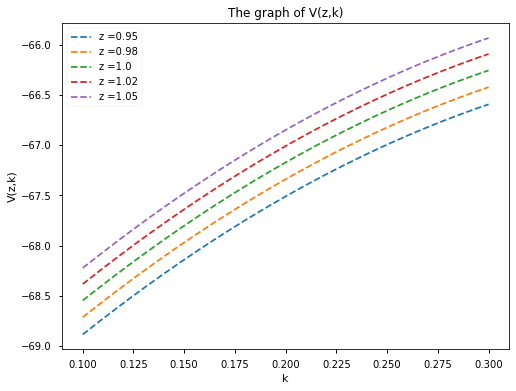

In [91]:
Model_4.Graphics()

#### Analysis

- It gives the same value function as in Ricatti and Vaughan. It is shifted above by 2. I think the reason is the fact that here, we solved for h and while solving for h there might be small error.
- Same analysis holds here.

# Question 2: The Same Model with Various Parameters

I will use LQ method to solve each case.

For each case, since ψ = 0, leisure is not valued by the consumer, so the optimal leisure is 0 and optimal labor is 1. This turns the problem what we have faced in homework 1 with Population and TFP growth. So we can slightly modify the model that we have done in homework 1.

Use the same tricks that we have done for question 1 and we get:

$$\max_{\hat k_{t+1}}\mathbb{E}\sum_{t=0}^{\infty} \hat{\beta}^t[log(\hat{k_t}^\alpha z_t^{1-\alpha} + (1-\delta)\hat{k_t} - \hat{\gamma}\hat{k_{t+1}}) + tlog(1+\gamma_z)]$$

$$s.t. \hat{\beta} = \beta (1+\gamma_n),\;\; \hat{\gamma} = (1+\gamma_n)(1+\gamma_z)$$


FOC:

$$(\hat k_{t+1}): \;\;\; \dfrac{\hat{\gamma}}{\hat k_t ^\alpha (z_t h_t)^{1-\alpha} + (1-\delta )\hat k_t- \hat{\gamma}\hat k_{t+1}} = \hat{\beta} \mathbb{E} \left[\dfrac{\alpha \hat{k_{t+1}}^{\alpha-1}z_{t+1}^{1-\alpha} + (1-\delta)}{\hat k_{t+1} ^\alpha z_{t+1}^{1-\alpha} + (1-\delta )\hat k_{t+1}- \hat{\gamma}\hat k_{t+2}} \right]$$


In steady state:

$$(\hat k): \;\;\; \hat{\gamma} = \hat{\beta} [\alpha \hat{k}^{\alpha-1} + (1-\delta)]$$

$$K_{ss} = \left[\dfrac{\dfrac{\hat \gamma}{\hat \beta} - (1 - \delta)}{\alpha} \right]^{\frac{1}{α  - 1}} $$

and as before, 

$$Z_{ss} = 1$$

So the steady state is:

$$(Z_{ss}, K_{ss}) = (1, \left[\dfrac{\dfrac{\hat \gamma}{\hat \beta} - (1 - \delta)}{\alpha} \right]^{\frac{1}{α  - 1}} )$$

Remember that in this question, the state variables are $x_t = \begin{bmatrix}z_t \\ \hat k_t\end{bmatrix}$ and control variables are $u_t = \hat k_{t+1}$, so R is 1x1 scalar, Q is 3x3 matrix, W is 3x1 vector.

We need to define Hessian and Jacobian as in HW1:

Our LQ code is the same that we did in Homework 1 but new steady states:

In [113]:
class LQ_no_leisure:
    """Our LQ Model"""

    def __init__(self, α=0.7, β=0.95, ρ=0.9, tol=10e-5, iterations=0, max_iter=10000, γ_z=0, γ_n=0, δ=0.9, θ=0.7):
        self.α = α
        self.β = β
        self.θ = θ
        self.ρ = ρ
        self.δ = δ
        self.tol = tol
        self.iterations = iterations
        self.max_iter = max_iter
        self.e = np.exp(1)

        self.γ_z = γ_z                   # growth rate of capital
        self.γ_n = γ_n                   # growth rate of population

        self.β_hat = β * (1 + γ_n)       # Normalized beta
        self.γ_hat = (1 + γ_n) * (1 + γ_z)  # Normalized gamma

        # Steady state value

        self.s1 = 1                                                    # z_ss
        self.s2 = (((self.γ_hat/self.β_hat) - (1 - δ)) / θ)**(1/(θ-1))  # k_ss
        self.d1 = (((self.γ_hat/self.β_hat) - (1 - δ)) / θ)**(1/(θ-1))  # k_ss

        # Steady state values
        self.Z = 0
        self.S = np.log((((self.γ_hat/self.β_hat) - (1 - δ)) / θ)
                        ** (1/(θ-1)))  # k_ss)
        self.D = np.log((((self.γ_hat/self.β_hat) - (1 - δ)) / θ)
                        ** (1/(θ-1)))  # k_ss)

    def R(self, z, s, d):  # Return Function
        return np.log(self.e**z * self.e**(self.α*s) - self.e**d)

    def derivatives(self):
        self.H = Derivatives_at_SS_no_leisure(
            self.R, self.Z, self.S, self.D).Hessian()  # Hessian
        self.J = Derivatives_at_SS_no_leisure(
            self.R, self.Z, self.S, self.D).Jacobian()  # Jacobian
        self.Return = self.R(self.Z, self.S, self.D)  # Return at steady state
        # Steady state values vector
        self.W_bar = np.matrix([self.Z, self.S, self.D]).T

    def Qanon(self):
        """Constructing Q Matrix"""
        Q11 = self.Return - np.matmul(self.W_bar.T, self.J) + 0.5 * \
            np.matmul(np.matmul(self.W_bar.T, self.H), self.W_bar)

        Q12 = 0.5 * (self.J - np.matmul(self.H, self.W_bar))

        Q22 = 0.5 * self.H

        self.Q = np.matrix([[Q11.item(0), Q12.item((0, 0)), Q12.item((1, 0)), Q12.item((2, 0))],
                            [Q12.item((0, 0)), Q22.item((0, 0)),
                             Q22.item((0, 1)), Q22.item((0, 2))],
                            [Q12.item((1, 0)), Q22.item((1, 0)),
                             Q22.item((1, 1)), Q22.item((1, 2))],
                            [Q12.item((2, 0)), Q22.item((2, 0)), Q22.item((2, 1)), Q22.item((2, 2))]])

    def Opt_value_fun(self):
        # To be able to easily extract values from Q, we transformed it into np.array
        Q_array = np.asarray(self.Q)

        self.Qff = np.asmatrix(Q_array[0:3, 0:3])  # Q_FF

        self.Qfd = np.asmatrix(Q_array[3, 0:3])  # Q_Fd

        self.Qdd = Q_array[3, 3]  # Q_dd

        self.B = np.matrix([[1, 0, 0, 0],
                            [0, self.ρ, 0, 0],
                            [0, 0, 0, 1]])

        self.P_0 = np.matrix([[-0.1, 0, 0],  # Initial guess of value function
                              [0, -0.1, 0],
                              [0, 0, -0.1]])

        self.P_1 = np.ones((3, 3))  # To be able to start iteration

    def VFI(self):
        β = self.β
        self.derivatives()
        self.Qanon()
        self.Opt_value_fun()

        while np.max(np.abs(self.P_1 - self.P_0) > self.tol) and self.iterations < self.max_iter:
            self.P_1 = np.copy(self.P_0)
            M = np.matmul(np.matmul(self.B.T, self.P_0), self.B)
            Mff = np.matrix([[M.item((0, 0)), M.item((0, 1)), M.item((0, 2))],
                             [M.item((1, 0)), M.item((1, 1)), M.item((1, 2))],
                             [M.item((2, 0)), M.item((2, 1)), M.item((2, 2))]])
            Mfd = np.matrix([[M.item(3, 0), M.item(3, 1), M.item(3, 2)]])
            Mdd = M.item((3, 3))
            self.P_0 = self.Qff + β * Mff - 1 / \
                (self.Qdd + β*Mdd) * \
                np.matmul((self.Qfd + β * Mfd).T, (self.Qfd + β * Mfd))
            self.iterations += 1

        self.P = np.copy(self.P_1)
        self.G = (-(self.Qdd + β * Mdd)**(-1)) * (self.Qfd + β * Mfd)

    def Graphics(self):
        self.VFI()
        fig, ax = plt.subplots()

        x = np.linspace(0.1, 1.5, 200)  # Capitals
        z = np.linspace(0.95, 1.05, 5)  # Technologies

        for j in range(len(z)):
            values = []
            for i in range(len(x)):
                v = np.matmul(np.matmul(np.matrix([1, np.log(z[j]), np.log(x[i])]), self.P), np.matrix(
                    [1, np.log(z[j]), np.log(x[i])]).T).item(0)
                values.append(v)

            ax.plot(x, values, '--', label="z =({})".format(round(z[j], 2)))
            ax.set_xlabel('k')
            ax.set_ylabel('V(z,k)')
            ax.title.set_text('The graph of V(z,k)')
            ax.legend()

        plt.show()


## The case of $ψ = 0, δ = 1, γ_n = 0, γ_z = 0$

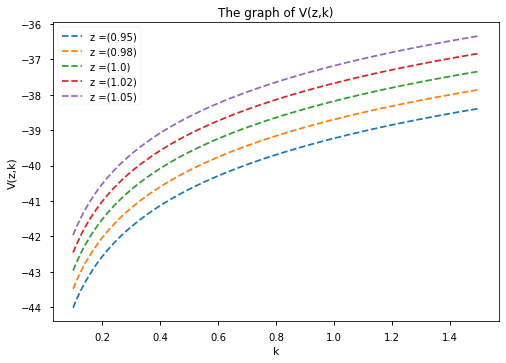

In [114]:
Case_1 = LQ_no_leisure()

Case_1.Graphics()

## The case of $ψ = 0, γ_n = 0, γ_z = 0$

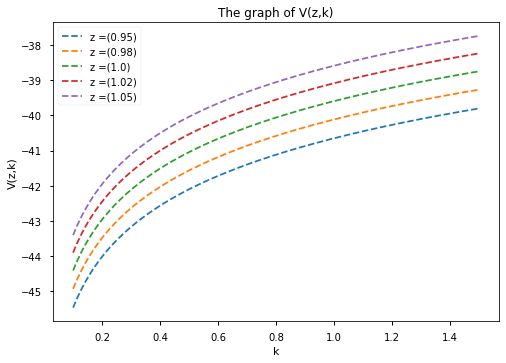

In [115]:
Case_2 = LQ_no_leisure(δ=0.8)

Case_2.Graphics()


## The case of $ψ = 0, γ_n = 0$

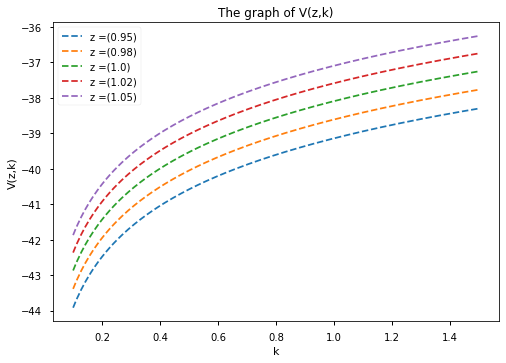

In [116]:
Case_3 = LQ_no_leisure(δ=0.8, γ_z=0.20)

Case_3.Graphics()


## The case of $ψ = 0, γ_z = 0$

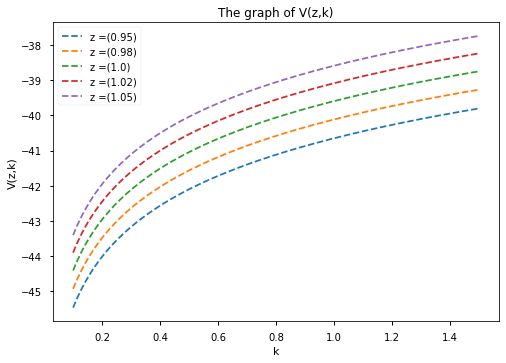

In [117]:
Case_4 = LQ_no_leisure(δ=0.8, γ_n=0.02)

Case_4.Graphics()


Case 2,3,4 are same because they have the same steady state.

## Question 3

Let's find the steady state and then do the same analysis.

The problem is:

$$\max_{\hat{k_{t+1}}, h_t}\mathbb{E}\sum_{t=0}^{\infty} \hat{\beta}^t\dfrac{[(\hat{k_t}^\alpha (z_th_t)^{1-\alpha} + (1-\delta)\hat{k_t} - \hat{\gamma}\hat k_{t+1})(1 - h_t)^\psi (1+\gamma_z)^t]^{1-\sigma}}{1-\sigma}$$

$$s.t. \hat{\beta} = \beta (1+\gamma_n),\;\; \hat{\gamma} = (1+\gamma_n)(1+\gamma_z)$$


Now, first of all, let's find z: $log(z_t) = \rho log(z_{t-1}) + \epsilon_t$ and when we are computing for steady state, we put means of the random variables. Let's assume $\epsilon \sim N(0, \sigma)$, then $log(z) = \rho log(z)$. Assuming $\rho < 1$, then z needs to be 1. 

$$z_{ss} = 1$$


FOC:

$$\small (h_t): \;\;\; \cancel{\hat \beta^t} \cancel{((1 + \gamma_z)^t)^{1- \sigma}} \left[ - \psi (1-h_t)^{\psi - 1} [\hat k_t^\alpha (z_th_t)^{1-\alpha} + (1-\delta)\hat k_t - \hat \gamma k_{t+1}] + (1- \alpha)\hat k_t^\alpha z_t^{1- \alpha} h_t^{-\alpha}(1-h_t)^\psi \right] \left[(\hat k_t^\alpha (z_th_t)^{1-\alpha} + (1-\delta) \hat k_t - \hat \gamma \hat k_{t+1}) (1-h_t)^\psi \right]^{-\sigma} = 0$$

If we continue to compute FOC's we would have the following equations:

$$ (h_t): \;\;\; \dfrac{(1-\alpha)\hat k_t^\alpha (z_t)^{1-\alpha} h_t^{-\alpha}}{\hat k_t ^\alpha (z_t h_t)^{1-\alpha} + (1-\delta )\hat k_t- \hat{\gamma}\hat k_{t+1}} = \dfrac{\psi}{1-h_t}$$

$$(\hat k_{t+1}): \;\;\; \dfrac{\hat{\gamma}}{\hat k_t ^\alpha (z_t h_t)^{1-\alpha} + (1-\delta )\hat k_t- \hat{\gamma}\hat k_{t+1}} = \hat{\beta} \mathbb{E}[\dfrac{\alpha \hat{k_{t+1}}^{\alpha-1}(z_{t+1}h_{t+1})^{1-\alpha} + (1-\delta)}{\hat k_{t+1} ^\alpha (z_{t+1} h_{t+1})^{1-\alpha} + (1-\delta )\hat k_{t+1}- \hat{\gamma}\hat k_{t+2}}]$$

And you can see that these are the same FOC equations of the first question. (Note: It makes sense to have same steady values since when  $\sigma \rightarrow 1$ the function turns into the function in the first question). Thus, they need to have the same steady state values.

So our steady state is:

$$(z_{ss}, h_{ss}, k_{ss}) = (1, [1 + \dfrac{\psi}{\Lambda \Theta}]^{-1}, \dfrac{1 - h_{ss}}{\psi} \Theta)$$

where,

$$ \Lambda = (\dfrac{\frac{\hat{\gamma}}{\hat{\beta}} - (1-\delta)}{\alpha})^{\frac{1}{1-\alpha}}$$

$$\Theta = \dfrac{(1-\alpha)\Lambda^{-1}}{\Lambda^{1-\alpha}+(1-\delta - \hat{\gamma})}$$

In [106]:
class LQ_with_power_utility:
    """Our LQ Model"""

    def __init__(self, p=0.9, δ=0.6, θ=0.4, β=0.72, γ_z=0.04, γ_n=0.15, ψ=0.3, tol=10e-2, max_iter=10000, sigma=0.3):
        self.p = p                       # \rho in AR(1) process in technology
        self.β = β                       # discount factor
        self.θ = θ                       # capital share
        self.δ = δ                       # depreciation rate of capital
        self.ψ = ψ                       # parameter for valuing leisure
        self.γ_z = γ_z                   # growth rate of capital
        self.γ_n = γ_n                   # growth rate of population
        self.sigma = sigma

        self.β_hat = β * (1 + γ_n)       # Normalized beta
        self.γ_hat = (1 + γ_n) * (1 + γ_z)  # Normalized gamma

        self.max_iter = max_iter         # Maximum iteration
        self.iterations = 0              # Iteration number of the VFI process
        self.tol = tol  # Tolerance of convergence

        # Steady state values
        self.Λ = (((self.γ_hat/self.β_hat) - (1-δ))/θ)**(1/(1-θ))  # aux
        self.Θ = ((1-θ)*(self.Λ)**(-θ)) / \
            ((self.Λ)**(1-θ)+(1-δ-self.γ_hat))  # aux

        self.s1 = 0  # z_ss
        self.d2 = (1 + ψ/(self.Λ * self.Θ))**(-1)  # h_ss
        self.s2 = ((1 - self.d2)/ψ) * self.Θ  # k_ss
        self.d1 = ((1 - self.d2)/ψ) * self.Θ  # k_ss

    def Ret(self, s1, s2, d1, d2):
        """One-period return function"""
        return (((s2**(self.θ)*((np.exp(s1)*d2)**(1-self.θ)) + (1-self.δ)*s2 - self.γ_hat * d1) * (1-d2)**(self.ψ))**(1-self.sigma))/(1-self.sigma)

    def construct_Q(self):
        """Create Jacobian,Hessian matrices and return value at the steady state and create big matrix (to find R,Q,W) correspondingly"""
        self.H = Derivatives_at_SS(
            self.Ret, self.s1, self.s2, self.d1, self.d2).Hessian()/2  # Hessian
        self.J = Derivatives_at_SS(
            self.Ret, self.s1, self.s2, self.d1, self.d2).Jacobian()/2  # Jacobian
        self.Return = np.array(self.Ret(self.s1, self.s2, self.d1,
                                        self.d2)).reshape((1, 1))  # Return at steady state

        first_row = np.concatenate([self.Return, self.J]).T
        rest_of_matrix = np.concatenate([self.J, self.H], axis=1)

        # Our big matrix to find Q,R,W
        self.big_matrix = np.concatenate([first_row, rest_of_matrix])

    def ABC_RQW(self):
        """Decomposes Big Matrix into R,Q,W and uses law of motinon to find A,B,C as well."""
        self.Q = self.big_matrix[0:3, 0:3]
        self.R = self.big_matrix[3:, 3:]
        self.W = self.big_matrix[0:3, 3:]

        self.A = np.array([[1, 0, 0],
                           [0, self.p, 0],
                           [0, 0, 0]])

        self.B = np.array([[0, 0],
                           [0, 0],
                           [1, 0]])

        self.C = np.array([[0],
                           [1],
                           [0]])

    def Normalize(self):
        """Normalizing"""
        self.A_tilde = np.sqrt(self.β_hat) * (self.A -
                                              self.B @ np.linalg.inv(self.R) @ self.W.T)

        self.B_tilde = np.sqrt(self.β_hat) * self.B

        self.Q_tilde = self.Q - (self.W @ np.linalg.inv(self.R) @ self.W.T)

    def convergence(self):
        self.construct_Q()
        self.ABC_RQW()
        self.Normalize()
        self.P_0 = np.array([[0, 0, 0],  # Initial guess of value function
                             [0, 0, 0],
                             [0, 0, 0]])

        self.P_1 = np.ones((3, 3))  # To be able to start iteration

        #P_0, P_1, Q, A, B, R = self.P_0, self.P_1, self.Q_tilde, self.A_tilde, self.B_tilde, self.R

        while np.max(np.abs(self.P_1 - self.P_0) > self.tol) and self.iterations < self.max_iter:
            self.P_0 = np.copy(self.P_1)
            self.P_1 = (self.Q_tilde + self.A_tilde.T @ self.P_0 @ self.A_tilde) - \
                self.A_tilde.T @ self.P_0 @ self.B_tilde @ (np.linalg.inv(self.R + self.B_tilde.T @
                                 self.P_0 @ self.B_tilde) @ self.B_tilde.T @ self.P_0 @ self.A_tilde)
            self.iterations += 1

        self.P = np.copy(self.P_1)
        self.F = (np.linalg.inv(self.R + self.B_tilde.T @ self.P_1 @ self.B_tilde) @ self.B_tilde.T @ self.P_1 @ self.A_tilde)

    def Graphics(self):
        self.convergence()
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        S1 = np.log(np.linspace(0.95, 1.05, 5) ) # Technologies
        S2 = np.linspace(0.01, 0.30, 200)  # Capitals

        for s1 in range(len(S1)):
            values = []
            policy_values = []
            for s2 in range(len(S2)):
                v = np.matmul(np.matmul(np.matrix([1, (S1[s1]) - (self.s1), S2[s2] - self.s2]), self.P), np.matrix(
                    [1, (S1[s1]) - (self.s1), S2[s2] - self.s2]).T).item(0)
                values.append(v)
                k = - np.matmul(self.F + np.matmul(np.linalg.inv(self.R), self.W.T), (np.array(
                    [[1], [(S1[s1]) - (self.s1)], [S2[s2] - self.s2]]))).item(0) + self.d1
                policy_values.append(k)

            ax[0].plot(S2, values, '--',
                       label="z =({})".format(round(S1[s1], 2)))
            ax[0].set_xlabel('k')
            ax[0].set_ylabel('V(z,k)')
            ax[0].title.set_text('The graph of V(z,k)')
            ax[0].legend()

            ax[1].plot(S2, policy_values, '--',
                       label="z =({})".format(round(S1[s1], 2)))
            ax[1].set_xlabel('k')
            ax[1].set_ylabel("k'")
            ax[1].title.set_text('The graph of optimal policy function')
            ax[1].axline((0, 0), (S2.max(), S2.max()))
            ax[1].legend()

        plt.show()


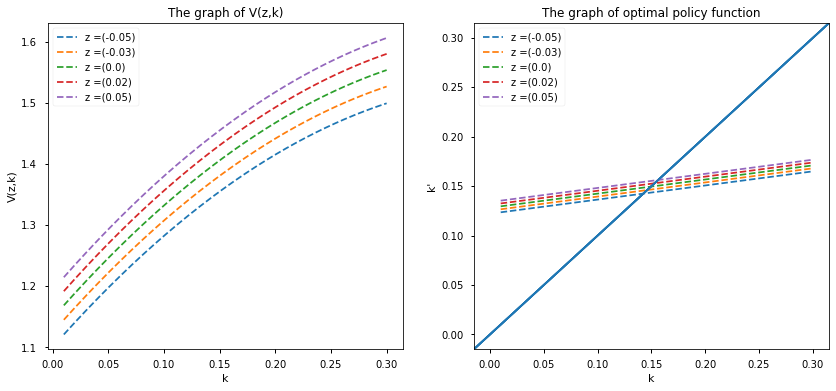

In [107]:
# σ = 0.2

Model_2 = LQ_with_power_utility(sigma=0.2)
Model_2.Graphics()

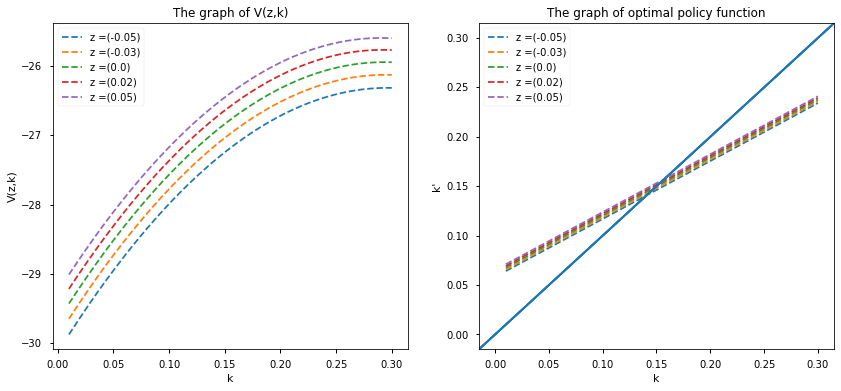

In [112]:
# σ = 0.99

Model_3 = LQ_with_power_utility(sigma=1.5)
Model_3.Graphics()

For high $\sigma$ case, we know that limit of the return function when $\sigma$ goes to 1 is log(), and we solved that case in Question 1